# 1. Parameters

In [1]:
from pathlib import Path
from os import mkdir
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

cases_root_dir = Path('cases')

figures_path = Path('figures')
if not figures_path.exists():
    mkdir(figures_path)
    
samples_cases = [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]
cases_paths = [cases_root_dir / f'case-{x}' for x in samples_cases]

metadata_file = Path('input/metadata-subsample-pangolin.tsv')

In [2]:
import genomics_data_index

print(genomics_data_index.__version__)

0.6.0.dev2


# 2. Indexing

## 2.1. Samples comparison

In [3]:
from typing import List

index_info_paths = [x / 'index-info.tsv' for x in cases_paths]
index_info_paths = [x for x in index_info_paths if x.exists()]

def read_all_df(index_paths: List[Path]) -> pd.DataFrame:
    dfs = []
    for index in index_paths:
        dfs.append(pd.read_csv(index, sep='\t'))
        
    return pd.concat(dfs).reset_index(drop=True)

index_info_df = read_all_df(index_info_paths)
index_info_df['Samples'] = index_info_df['Name'].str.extract(r'^case-(\d+)').astype(int)
index_info_df['Number features (unknown)'] = index_info_df['Number features (all)'] - \
                                             index_info_df['Number features (no unknown)']
index_info_df[
    'Percent of reference genome with unknown/missing features'] = 100 * (index_info_df[
    'Number features (unknown)'] / index_info_df['Reference length'])
index_info_df.head(5)

,Name,Reference name,Iteration,Number samples,Number features (all),Number features (no unknown),Number cores,Reference length,Analysis runtime,Analysis memory (max),...,Index memory (max/process),Index size,Tree runtime,Tree memory (max),Tree memory (max/process),Total runtime,Max memory,Samples,Number features (unknown),Percent of reference genome with unknown/missing features
0,case-10,NC_045512,1,10,2900,44,32,29903,154.95,1.393578e+09,...,236605440.0,757760.0,94.39,251297792.0,221229056.0,254.01,5.421670e+09,10,2856,9.550881
1,case-10,NC_045512,2,10,2900,44,32,29903,151.19,1.383870e+09,...,236941312.0,761856.0,84.07,249954304.0,221487104.0,239.87,5.418443e+09,10,2856,9.550881
2,case-10,NC_045512,3,10,2900,44,32,29903,149.23,1.430385e+09,...,236781568.0,761856.0,96.14,251609088.0,221868032.0,250.09,5.416673e+09,10,2856,9.550881
3,case-20,NC_045512,1,20,11560,61,32,29903,150.40,1.601839e+09,...,273526784.0,1957888.0,107.29,243322880.0,222175232.0,264.26,5.540147e+09,20,11499,38.454336
4,case-20,NC_045512,2,20,11560,61,32,29903,151.23,1.677283e+09,...,273903616.0,1966080.0,106.86,243453952.0,222339072.0,264.85,5.536125e+09,20,11499,38.454336


In [4]:
reference_length = index_info_df['Reference length'].value_counts().index[0]
reference_length

29903

### 2.1.1. Common styles 

In [5]:
stages_palette = ['#1b9e77', '#7570b3', '#d95f02', '#000000']
stages_markers = ['o', 's', '^', 'X']
stages_palette_nototal = ['#1b9e77', '#7570b3', '#d95f02']
stages_markers_nototal = ['o', 's', '^']
stages_palette_notree = ['#1b9e77', '#7570b3', '#000000']
stages_markers_notree = ['o', 's', 'X']

### 2.1.2. Runtime plots

In [6]:
from typing import Callable

def melt_runtimes(df: pd.DataFrame, include_tree_na: bool, id_vars: str) -> pd.DataFrame:
    df = df.copy()
    if include_tree_na:
        df = df[~df['Tree runtime'].isna()]
        value_vars = ['Analysis runtime', 'Index runtime', 'Tree runtime', 'Total runtime']
    else:
        df['Total runtime'] = df['Analysis runtime'] + df['Index runtime']
        value_vars = ['Analysis runtime', 'Index runtime', 'Total runtime']
    df = pd.melt(df, id_vars=id_vars,
            value_vars=value_vars)
    df = df.rename({'variable': 'Stage', 'value': 'Time (seconds)'}, axis='columns')
    df['Stage'] = df['Stage'].str.replace(' runtime', '', regex=False)
    df['Time (minutes)'] = df['Time (seconds)'] / 60
    df['Time (hours)'] = df['Time (seconds)'] / 3600
    return df

def melt_and_combine_with_without_tree(df: pd.DataFrame, melt_func: Callable[[pd.DataFrame, bool, str], pd.DataFrame],
                                      id_vars: str) -> pd.DataFrame:
    tree_df = melt_func(df, include_tree_na=True, id_vars=id_vars)
    tree_df['Type'] = 'Include Tree'
    ntree_df = melt_func(df, include_tree_na=False, id_vars=id_vars)
    ntree_df['Type'] = 'Exclude Tree'
    
    return pd.concat([tree_df, ntree_df])

In [7]:
index_info_runtime_df = melt_and_combine_with_without_tree(index_info_df,
                                                           melt_func=melt_runtimes,
                                                           id_vars='Samples')
index_info_runtime_df

,Samples,Stage,Time (seconds),Time (minutes),Time (hours),Type
0,10,Analysis,154.95,2.582500,0.043042,Include Tree
1,10,Analysis,151.19,2.519833,0.041997,Include Tree
2,10,Analysis,149.23,2.487167,0.041453,Include Tree
3,20,Analysis,150.40,2.506667,0.041778,Include Tree
4,20,Analysis,151.23,2.520500,0.042008,Include Tree
...,...,...,...,...,...,...
94,10000,Total,4531.01,75.516833,1.258614,Exclude Tree
95,10000,Total,4486.01,74.766833,1.246114,Exclude Tree
96,20000,Total,9113.62,151.893667,2.531561,Exclude Tree
97,20000,Total,9194.05,153.234167,2.553903,Exclude Tree


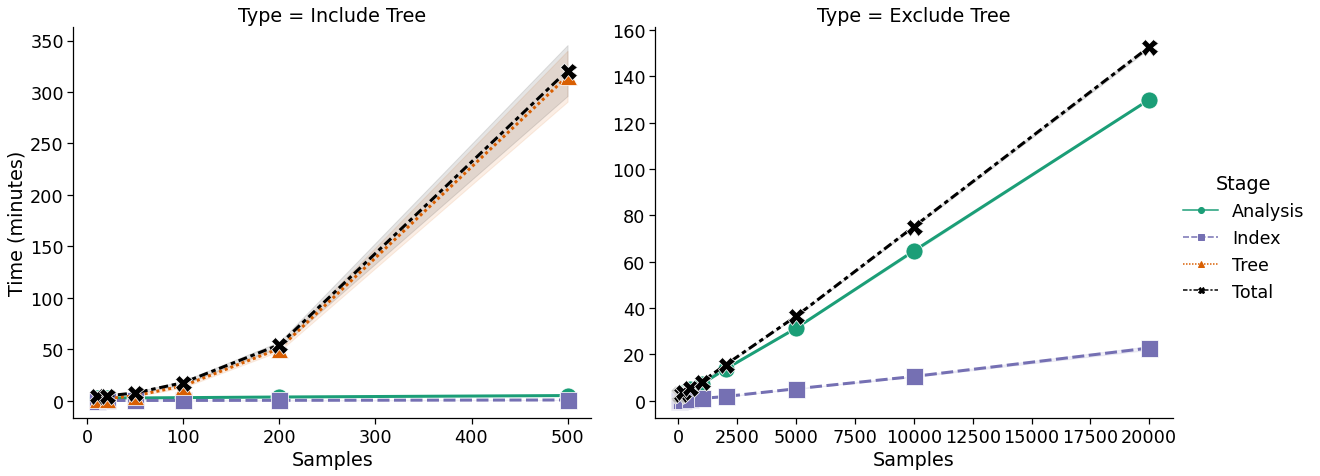

In [8]:
with sns.plotting_context("notebook", font_scale=1.6):
    g = sns.relplot(x='Samples', y='Time (minutes)', hue="Stage", style="Stage", ci="sd", kind="line",
                    data=index_info_runtime_df, col="Type", markers=stages_markers, estimator='mean',
                    height=7, aspect=1.2, linewidth=3, markersize=17, err_kws={"alpha": 0.1},
                    palette=stages_palette,
                    facet_kws={'sharey': False, 'sharex': False})
    plt.savefig('figures/index-runtime.pdf')

#### 2.1.2.1. Mean/stdevs

In [9]:
index_info_runtime_df.groupby(['Samples', 'Stage', 'Type']).agg(['mean', 'std', 'count'])

Time (seconds)                     \
                                        mean          std count   
Samples Stage    Type                                             
10      Analysis Exclude Tree     151.790000     2.906820     3   
                 Include Tree     151.790000     2.906820     3   
        Index    Exclude Tree       4.666667     0.055076     3   
                 Include Tree       4.666667     0.055076     3   
        Total    Exclude Tree     156.456667     2.891476     3   
                 Include Tree     247.990000     7.300164     3   
        Tree     Include Tree      91.533333     6.522395     3   
20      Analysis Exclude Tree     154.110000     5.722176     3   
                 Include Tree     154.110000     5.722176     3   
        Index    Exclude Tree       6.763333     0.195021     3   
                 Include Tree       6.763333     0.195021     3   
        Total    Exclude Tree     160.873333     5.899511     3   
                 Include Tree     273.136667    14.866810     3   
        Tree     Include Tree     112.263333     8.989028     3   
50      Analysis Exclude Tree     155.906667     3.571195     3   
                 Include Tree     155.906667     3.571195     3   
        Index    Exclude Tree       8.923333     0.161658     3   
                 Include Tree       8.923333     0.161658     3   
        Total    Exclude Tree     164.830000     3.682241     3   
                 Include Tree     450.346667    54.723425     3   
        Tree     Include Tree     285.516667    51.379948     3   
100     Analysis Exclude Tree     173.363333     7.784769     3   
                 Include Tree     173.363333     7.784769     3   
        Index    Exclude Tree      11.026667     0.222336     3   
                 Include Tree      11.026667     0.222336     3   
        Total    Exclude Tree     184.390000     7.952100     3   
                 Include Tree    1048.553333   107.392089     3   
        Tree     Include Tree     864.163333    99.472387     3   
200     Analysis Exclude Tree     210.020000    11.467188     3   
                 Include Tree     210.020000    11.467188     3   
        Index    Exclude Tree      16.110000     0.756241     3   
                 Include Tree      16.110000     0.756241     3   
        Total    Exclude Tree     226.130000    12.055252     3   
                 Include Tree    3261.040000   169.256307     3   
        Tree     Include Tree    3034.910000   157.538196     3   
500     Analysis Exclude Tree     294.966667     3.496775     3   
                 Include Tree     294.966667     3.496775     3   
        Index    Exclude Tree      35.913333     0.719328     3   
                 Include Tree      35.913333     0.719328     3   
        Total    Exclude Tree     330.880000     2.778489     3   
                 Include Tree   19251.213333  1484.658632     3   
        Tree     Include Tree   18920.333333  1486.694432     3   
1000    Analysis Exclude Tree     438.396667    16.670037     3   
        Index    Exclude Tree      59.120000     3.479095     3   
        Total    Exclude Tree     497.516667    13.353106     3   
2000    Analysis Exclude Tree     820.950000     7.473440     3   
        Index    Exclude Tree     109.056667     2.061488     3   
        Total    Exclude Tree     930.006667     9.390795     3   
5000    Analysis Exclude Tree    1881.900000     5.418967     3   
        Index    Exclude Tree     309.873333     2.828787     3   
        Total    Exclude Tree    2191.773333     7.462817     3   
10000   Analysis Exclude Tree    3882.000000    32.046841     3   
        Index    Exclude Tree     628.700000    13.612799     3   
        Total    Exclude Tree    4510.700000    22.817500     3   
20000   Analysis Exclude Tree    7802.000000     2.645751     3   
        Index    Exclude Tree    1365.730000    49.474128     3   
        Total    Exclude Tree    9167.730000    46.866398     3   

         

### 2.1.3. Analysis memory plots

In [10]:
def melt_memory(df: pd.DataFrame, include_tree_na: bool, id_vars: str) -> pd.DataFrame:
    if include_tree_na:
        df = df[~df['Tree memory (max)'].isna()]
        value_vars = ['Analysis memory (max)', 'Index memory (max)', 'Tree memory (max)']
    else:
        value_vars = ['Analysis memory (max)', 'Index memory (max)']

    df = pd.melt(df, id_vars=id_vars,
            value_vars=value_vars)
    df['value'] = df['value'].apply(lambda x: x/(1024**3))
    df = df.rename({'variable': 'Stage', 'value': 'Peak Memory (GB)'}, axis='columns')
    df['Stage'] = df['Stage'].str.replace(' memory (max)', '', regex=False)
    return df

In [11]:
index_info_memory_df = melt_and_combine_with_without_tree(index_info_df,
                                                          melt_func=melt_memory,
                                                          id_vars='Samples')
index_info_memory_df

,Samples,Stage,Peak Memory (GB),Type
0,10,Analysis,1.297871,Include Tree
1,10,Analysis,1.288830,Include Tree
2,10,Analysis,1.332150,Include Tree
3,20,Analysis,1.491829,Include Tree
4,20,Analysis,1.562092,Include Tree
...,...,...,...,...
61,10000,Index,26.993298,Exclude Tree
62,10000,Index,27.887939,Exclude Tree
63,20000,Index,33.390953,Exclude Tree
64,20000,Index,32.585884,Exclude Tree


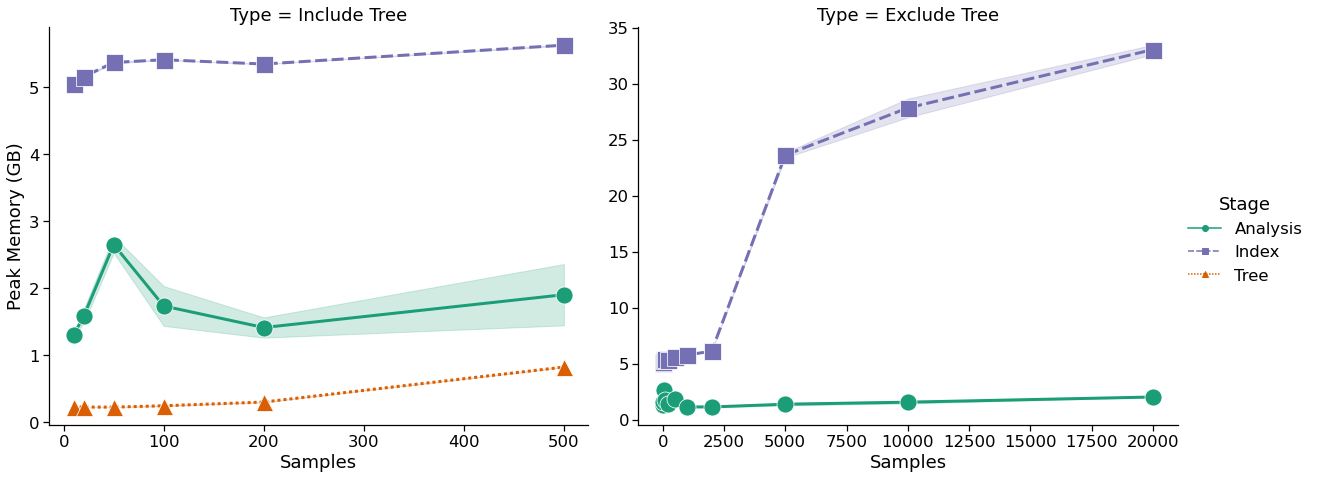

In [12]:
with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.relplot(x='Samples', y='Peak Memory (GB)', hue="Stage", style="Stage", ci="sd", kind="line",
                    data=index_info_memory_df, markers=stages_markers_nototal, estimator='mean', col="Type",
                    height=7, aspect=1.2, linewidth=3, markersize=17, err_kws={"alpha": 0.2},
                    palette=stages_palette_nototal,
                    facet_kws={'sharey': False, 'sharex': False})
    plt.savefig('figures/index-memory.pdf')

#### 2.1.3.1. Mean/stddev

In [13]:
index_info_memory_df.groupby(['Samples', 'Stage', 'Type']).agg(['mean', 'std', 'count'])

Peak Memory (GB)                
                                          mean       std count
Samples Stage    Type                                         
10      Analysis Exclude Tree         1.306283  0.022852     3
                 Include Tree         1.306283  0.022852     3
        Index    Exclude Tree         5.046771  0.002360     3
                 Include Tree         5.046771  0.002360     3
        Tree     Include Tree         0.233719  0.000819     3
20      Analysis Exclude Tree         1.584047  0.104932     3
                 Include Tree         1.584047  0.104932     3
        Index    Exclude Tree         5.159999  0.004258     3
                 Include Tree         5.159999  0.004258     3
        Tree     Include Tree         0.226606  0.000132     3
50      Analysis Exclude Tree         2.653482  0.125151     3
                 Include Tree         2.653482  0.125151     3
        Index    Exclude Tree         5.373664  0.015964     3
                 Include Tree         5.373664  0.015964     3
        Tree     Include Tree         0.225802  0.000712     3
100     Analysis Exclude Tree         1.736018  0.297237     3
                 Include Tree         1.736018  0.297237     3
        Index    Exclude Tree         5.413890  0.001347     3
                 Include Tree         5.413890  0.001347     3
        Tree     Include Tree         0.246324  0.006091     3
200     Analysis Exclude Tree         1.414392  0.151097     3
                 Include Tree         1.414392  0.151097     3
        Index    Exclude Tree         5.350028  0.002235     3
                 Include Tree         5.350028  0.002235     3
        Tree     Include Tree         0.301792  0.002092     3
500     Analysis Exclude Tree         1.904853  0.457993     3
                 Include Tree         1.904853  0.457993     3
        Index    Exclude Tree         5.631448  0.005641     3
                 Include Tree         5.631448  0.005641     3
        Tree     Include Tree         0.824327  0.002684     3
1000    Analysis Exclude Tree         1.162089  0.024773     3
        Index    Exclude Tree         5.788335  0.002879     3
2000    Analysis Exclude Tree         1.156297  0.019687     3
        Index    Exclude Tree         6.147240  0.006539     3
5000    Analysis Exclude Tree         1.400332  0.109506     3
        Index    Exclude Tree        23.638526  0.228717     3
10000   Analysis Exclude Tree         1.584035  0.119532     3
        Index    Exclude Tree        27.848876  0.836730     3
20000   Analysis Exclude Tree         2.044973  0.003324     3
        Index    Exclude Tree        33.063883  0.423224     3

#### 2.1.3.2. Number of features vs memory

In [14]:
# memory_features_df = melt_memory(index_info_df,
#                                             include_tree_na=False,
#                                             id_vars=['Samples',
#                                                      'Number features (no unknown)'])
# memory_features_df = memory_features_df.rename({'Number features (no unknown)': 'Number of features'}, axis='columns')
# memory_features_df['Feature Type'] = 'Variant calls'

memory_unknown_features_df = melt_memory(index_info_df,
                                            include_tree_na=False,
                                            id_vars=['Samples',
                                                     'Number features (unknown)'])
memory_unknown_features_df = memory_unknown_features_df.rename({'Number features (unknown)': 'Number of features'}, axis='columns')
memory_unknown_features_df['Feature Type'] = 'Unknown/missing'

memory_all_features_df = melt_memory(index_info_df,
                                            include_tree_na=False,
                                            id_vars=['Samples',
                                                     'Number features (all)'])
memory_all_features_df = memory_all_features_df.rename({'Number features (all)': 'Number of features'}, axis='columns')
memory_all_features_df['Feature Type'] = 'All'

memory_features_combined_df = pd.concat([memory_unknown_features_df, memory_all_features_df])
memory_features_combined_df = memory_features_combined_df[memory_features_combined_df['Stage'] == 'Index']
memory_features_combined_df['Number of samples'] = memory_features_combined_df['Samples']
memory_features_combined_df.loc[memory_features_combined_df['Samples'] <= 2000, 'Number of samples'] = '≤ 2000'

memory_features_combined_df.tail(10)

,Samples,Number of features,Stage,Peak Memory (GB),Feature Type,Number of samples
56,2000,32489,Index,6.149857,All,≤ 2000
57,5000,35663,Index,23.776958,All,5000
58,5000,35663,Index,23.764088,All,5000
59,5000,35663,Index,23.374531,All,5000
60,10000,39089,Index,28.665390,All,10000
61,10000,39089,Index,26.993298,All,10000
62,10000,39089,Index,27.887939,All,10000
63,20000,45709,Index,33.390953,All,20000
64,20000,45709,Index,32.585884,All,20000
65,20000,45709,Index,33.214813,All,20000


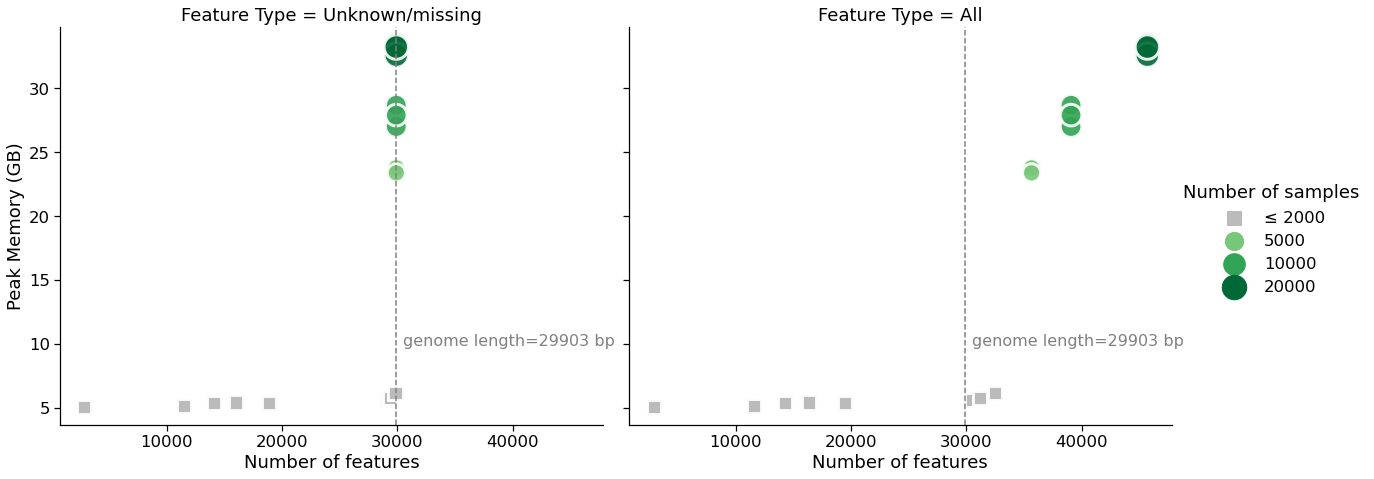

In [15]:
with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.relplot(x='Number of features', y='Peak Memory (GB)', col="Feature Type",
                    size='Number of samples', style='Number of samples',
                    kind="scatter", s=100, alpha=0.9, hue='Number of samples',
                    sizes=(600, 200), palette=['#bbbbbb', '#78c679', '#31a354', '#006837'],
                    data=memory_features_combined_df, markers=["s", "o", "o", "o"],
                    height=7, aspect=1.2, linewidth=3,
                    )
    
    reference_size = index_info_df['Reference length'].value_counts().index[0]
    for ax in g.axes.flat:
        ax.axvline(reference_size, color='gray', ls='--')
        ylim = ax.get_ylim()
        ylen = ylim[1] - ylim[0]
        ypos = ylim[1] - ylen * 0.8
        xpos = reference_size + reference_size * 0.02
        ax.text(xpos, ypos, f'genome length={reference_size} bp', fontdict={'size': 16, 'color': 'gray'})
        
    plt.savefig('figures/index-memory-features.pdf')

#### 2.1.3.3. Memory batch size 10,000

In [16]:
index_info_memory_subset_df = index_info_memory_df.copy()[
    index_info_memory_df['Samples'].isin([2000, 5000, 10000, 20000])]
index_info_memory_subset_df['Sample Batch Size'] = 2000
index_info_memory_subset_df.head(5)

,Samples,Stage,Peak Memory (GB),Type,Sample Batch Size
21,2000,Analysis,1.141163,Exclude Tree,2000
22,2000,Analysis,1.149174,Exclude Tree,2000
23,2000,Analysis,1.178555,Exclude Tree,2000
24,5000,Analysis,1.280212,Exclude Tree,2000
25,5000,Analysis,1.494598,Exclude Tree,2000


In [17]:
cases_batch_paths = [cases_root_dir / f'case-{x}-batch-10000' for x in [2000, 5000, 10000, 20000]]
index_info_batch_paths = [x / 'index-info.tsv' for x in cases_batch_paths]

index_info_batch_df = read_all_df(index_info_batch_paths)
index_info_batch_df['Samples'] = index_info_batch_df['Number samples'].astype(int)
index_info_batch_df.head(4)

,Name,Reference name,Iteration,Number samples,Number features (all),Number features (no unknown),Number cores,Reference length,Analysis runtime,Analysis memory (max),...,Index runtime,Index memory (max),Index memory (max/process),Index size,Tree runtime,Tree memory (max),Tree memory (max/process),Total runtime,Max memory,Samples
0,case-2000-batch-10000,NC_045512,1,2000,32489,2656,32,29903,837.14,1.241031e+09,...,108.47,6.595265e+09,1.210929e+09,39854080.0,NaN,NaN,NaN,945.61,6.595265e+09,2000
1,case-2000-batch-10000,NC_045512,2,2000,32489,2656,32,29903,825.97,1.273147e+09,...,109.39,6.591537e+09,1.219588e+09,39874560.0,NaN,NaN,NaN,935.36,6.591537e+09,2000
2,case-2000-batch-10000,NC_045512,3,2000,32489,2656,32,29903,824.21,1.215754e+09,...,109.95,6.593950e+09,1.209250e+09,39866368.0,NaN,NaN,NaN,934.16,6.593950e+09,2000
3,case-5000-batch-10000,NC_045512,1,5000,35663,5760,32,29903,1876.88,1.450340e+09,...,266.29,8.373756e+09,2.992312e+09,94507008.0,NaN,NaN,NaN,2143.17,8.373756e+09,5000


In [18]:
index_info_memory_batch_df = melt_and_combine_with_without_tree(index_info_batch_df,
                                                          melt_func=melt_memory,
                                                          id_vars='Samples')
index_info_memory_batch_df['Sample Batch Size'] = 10000
index_info_memory_batch_df.head(5)

,Samples,Stage,Peak Memory (GB),Type,Sample Batch Size
0,2000,Analysis,1.155800,Exclude Tree,10000
1,2000,Analysis,1.185711,Exclude Tree,10000
2,2000,Analysis,1.132259,Exclude Tree,10000
3,5000,Analysis,1.350735,Exclude Tree,10000
4,5000,Analysis,1.300987,Exclude Tree,10000


In [19]:
memory_batch_combined_df = pd.concat([index_info_memory_subset_df, index_info_memory_batch_df])
memory_batch_combined_df = memory_batch_combined_df[memory_batch_combined_df['Stage'] == 'Index']
memory_batch_combined_df = memory_batch_combined_df.rename({
    'Peak Memory (GB)': 'Peak Memory for Index (GB)'}, axis='columns')
memory_batch_combined_df

,Samples,Stage,Peak Memory for Index (GB),Type,Sample Batch Size
54,2000,Index,6.139797,Exclude Tree,2000
55,2000,Index,6.152065,Exclude Tree,2000
56,2000,Index,6.149857,Exclude Tree,2000
57,5000,Index,23.776958,Exclude Tree,2000
58,5000,Index,23.764088,Exclude Tree,2000
59,5000,Index,23.374531,Exclude Tree,2000
60,10000,Index,28.665390,Exclude Tree,2000
61,10000,Index,26.993298,Exclude Tree,2000
62,10000,Index,27.887939,Exclude Tree,2000
63,20000,Index,33.390953,Exclude Tree,2000


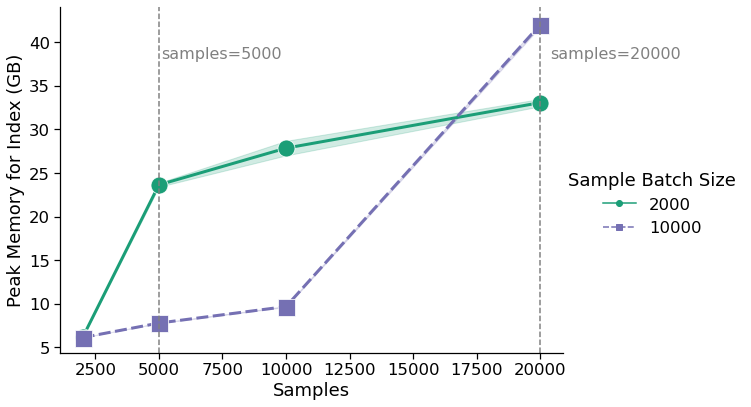

In [20]:
with sns.plotting_context("notebook", font_scale=1.5):
    batch_palette = ['#1b9e77', '#7570b3']
    batch_markers = ['o', 's']
    
    g = sns.relplot(x='Samples', y='Peak Memory for Index (GB)', hue="Sample Batch Size", 
                    style="Sample Batch Size", ci="sd", kind="line",
                    data=memory_batch_combined_df, estimator='mean',
                    markers=batch_markers,
                    palette=batch_palette,
                    height=6, aspect=1.4, linewidth=3, markersize=17, err_kws={"alpha": 0.2})
    
    for ax in g.axes.flat:
        for line in [5000, 20000]:
            ax.axvline(line, color='gray', ls='--')
            ylim = ax.get_ylim()
            ylen = ylim[1] - ylim[0]
            ypos = ylim[1] - ylen * 0.15
            xpos = line + line * 0.02
            ax.text(xpos, ypos, f'samples={line}', fontdict={'size': 16, 'color': 'gray'})
    plt.savefig('figures/index-memory-sample-batch-size.pdf')

### 2.1.4. Disk usage plots

In [21]:
def melt_disk_usage(df: pd.DataFrame, id_vars: str) -> pd.DataFrame:
    df = df.copy()
    df['Total size'] = df['Analysis disk uage'] + df['Index size']
    df = pd.melt(df, id_vars=id_vars,
            value_vars=['Analysis disk uage', 'Index size', 'Total size'])
    df['value'] = df['value'].apply(lambda x: x/(1024**3))
    df = df.rename({'variable': 'Stage', 'value': 'Disk (GB)'}, axis='columns')
    df['Stage'] = df['Stage'].str.replace(' disk uage', '', regex=False)
    df['Stage'] = df['Stage'].str.replace(' size', '', regex=False)
    return df
index_info_disk_df = melt_disk_usage(index_info_df, id_vars='Samples')
index_info_disk_df.head(3)

,Samples,Stage,Disk (GB)
0,10,Analysis,3.431393
1,10,Analysis,3.431408
2,10,Analysis,3.431393


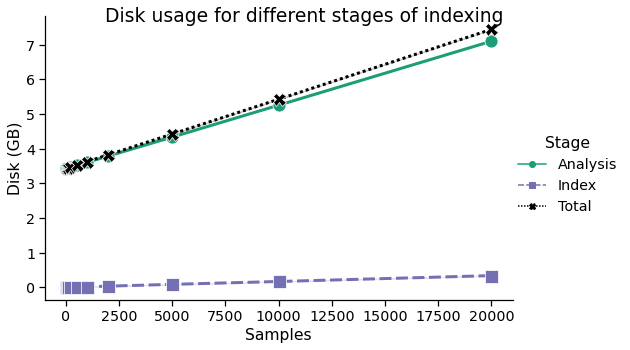

In [22]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Samples', y='Disk (GB)', hue="Stage", style="Stage", ci="sd", kind="line",
                    data=index_info_disk_df, markers=stages_markers_notree, estimator='mean',
                    palette=stages_palette_notree,
                    height=5, aspect=1.5, linewidth=3, markersize=13, err_kws={"alpha": 0.2})
    g.fig.suptitle("Disk usage for different stages of indexing")
    plt.savefig('figures/index-disk-usage.pdf')

#### 2.1.4.1. Mean/stddev

In [23]:
index_info_disk_df.groupby(['Samples', 'Stage']).agg(['mean', 'std', 'count'])

Disk (GB)                
                      mean       std count
Samples Stage                             
10      Analysis  3.431398  0.000009     3
        Index     0.000708  0.000002     3
        Total     3.432106  0.000010     3
20      Analysis  3.433208  0.000011     3
        Index     0.001829  0.000004     3
        Total     3.435037  0.000008     3
50      Analysis  3.438718  0.000002     3
        Index     0.002633  0.000002     3
        Total     3.441352  0.000002     3
100     Analysis  3.447838  0.000014     3
        Index     0.003679  0.000002     3
        Total     3.451516  0.000015     3
200     Analysis  3.464698  0.000006     3
        Index     0.005669  0.000007     3
        Total     3.470366  0.000002     3
500     Analysis  3.519265  0.000141     3
        Index     0.012371  0.000008     3
        Total     3.531637  0.000134     3
1000    Analysis  3.611285  0.000021     3
        Index     0.020529  0.000010     3
        Total     3.631814  0.000028     3
2000    Analysis  3.792365  0.000760     3
        Index     0.037139  0.000013     3
        Total     3.829503  0.000773     3
5000    Analysis  4.337861  0.000004     3
        Index     0.088715  0.000025     3
        Total     4.426576  0.000021     3
10000   Analysis  5.258503  0.000082     3
        Index     0.171040  0.000050     3
        Total     5.429543  0.000033     3
20000   Analysis  7.104769  0.000160     3
        Index     0.340861  0.000071     3
        Total     7.445630  0.000100     3

# 3. Querying

## 3.1. Querying API

In [24]:
def load_query_df(query_api_file_name: str) -> pd.DataFrame:
    query_paths = [x / query_api_file_name for x in cases_paths]
    query_paths = [x for x in query_paths if x.exists()]

    query_df = read_all_df(query_paths)
    query_df['Samples'] = query_df['Name'].str.extract(r'^case-(\d+)').astype(int)
    query_df['Time'] = query_df['Time'].apply(lambda x: x * 1000)
    query_df['Number features (unknown)'] = query_df['Number features (all)'] \
                                                          - query_df['Number features (no unknown)']
    query_df['Number of features (thousands)'] = query_df['Number features (all)'] / 1000
    query_df['Number of non-unknown features (thousands)'] = query_df['Number features (no unknown)'] / 1000
    query_df['Number of unknown features (thousands)'] = query_df['Number features (unknown)'] / 1000
    query_df = query_df.rename({'Time': 'Time (ms)'}, axis='columns')

    # Remove isin queries to ignore queries involving a tree
    query_df = query_df[~query_df['Kind'].str.contains('isin')]

    # Remove db.samples_query since I don't really need the times
    query_df = query_df[~query_df['Kind'].str.contains('db.samples_query')]

    # Divide up kinds of queries into classes
    query_df['Time scale'] = 'Short'
    query_df.loc[query_df['Kind'].isin(
        ['q.toframe', 'q.hasa', 'q.join', 'q.features_summary']), 'Time scale'] = 'Medium'
    query_df.loc[query_df['Kind'].isin(
        ['q.features_comparison']), 'Time scale'] = 'Long'

    query_df = query_df.sort_values('Time scale', ascending=False)

    return query_df

query_df = load_query_df(query_api_file_name='query-api.tsv')
query_df.head(5)

,Name,Kind,Number samples,Number features (no unknown),Number features (all),Number executions,Iteration,Time (ms),Samples,Number features (unknown),Number of features (thousands),Number of non-unknown features (thousands),Number of unknown features (thousands),Time scale
600,case-500,q.isa,500,1401,30534,1000,1,0.391558,500,29133,30.534,1.401,29.133,Short
616,case-500,q AND r,500,1401,30534,10000,7,0.021436,500,29133,30.534,1.401,29.133,Short
638,case-500,q.summary,500,1401,30534,1000,9,0.351866,500,29133,30.534,1.401,29.133,Short
637,case-500,q.summary,500,1401,30534,1000,8,0.353045,500,29133,30.534,1.401,29.133,Short
636,case-500,q.summary,500,1401,30534,1000,7,0.355751,500,29133,30.534,1.401,29.133,Short


### 3.1.1. Compare runtime for single set of samples

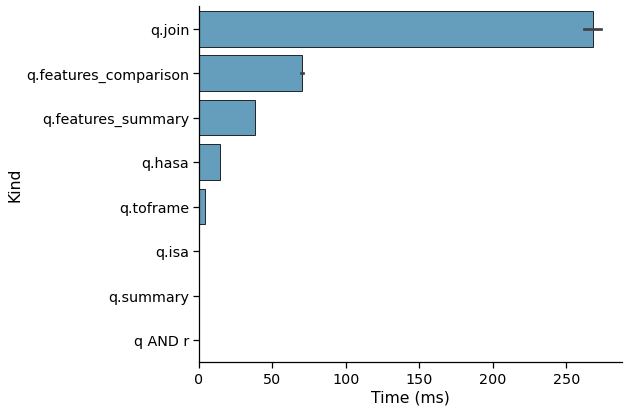

In [25]:
query_samples = query_df[query_df['Samples'] == 100]
query_samples = query_samples.sort_values('Time (ms)', ascending=False)
query_samples

with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.catplot(
        data=query_samples, kind="bar",
        y="Kind", x="Time (ms)", hue=None,
        ci="sd", height=6, aspect=1.5, alpha=0.8, color="#2b8cbe", edgecolor="black"
    )
    plt.savefig('figures/query-api-runtime-100.pdf')

### 3.1.2. Compare runtime vs. all samples

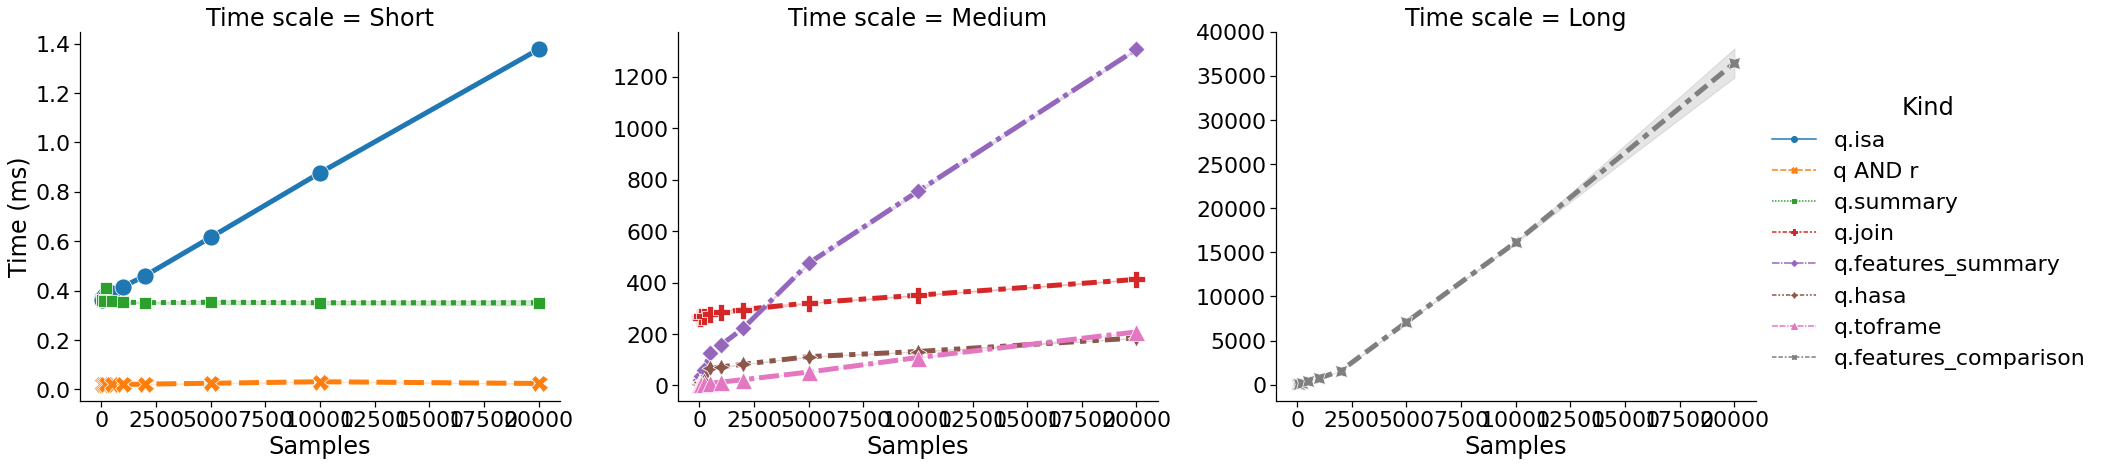

In [26]:
with sns.plotting_context("notebook", font_scale=2):
    g = sns.relplot(x='Samples', y='Time (ms)', hue="Kind", style="Kind", ci="sd", kind="line",
                    data=query_df, markers=True, estimator='mean', col="Time scale",
                    height=7, aspect=1.2, linewidth=5, markersize=17, err_kws={"alpha": 0.2},
                    facet_kws={'sharey': False, 'sharex': True})
    plt.savefig('figures/query-api-runtime.pdf')

#### 3.1.2.1. mean/stdev

In [27]:
query_mean_df = query_df.groupby(['Name', 'Kind']).agg({'Time (ms)': ['mean', 'std', 'count'],
                                                        'Number features (all)': ['mean', 'std']})
query_mean_df.loc[['case-2000', 'case-5000', 'case-10000', 'case-20000']]

Time (ms)                     \
                                          mean          std count   
Name       Kind                                                     
case-2000  q AND r                    0.021169     0.000086    10   
           q.features_comparison   1578.084162     6.770573    10   
           q.features_summary       221.397597     1.124426    10   
           q.hasa                    82.205455     0.365472    10   
           q.isa                      0.459830     0.000544    10   
           q.join                   294.885043     9.830879    10   
           q.summary                  0.350946     0.003254    10   
           q.toframe                 21.900078     0.055444    10   
case-5000  q AND r                    0.024698     0.000118    10   
           q.features_comparison   7088.827784    37.073113    10   
           q.features_summary       474.915097     4.648915    10   
           q.hasa                   111.696785     0.337070    10   
           q.isa                      0.615471     0.000881    10   
           q.join                   320.668463     1.147858    10   
           q.summary                  0.352822     0.007849    10   
           q.toframe                 51.758294     0.133387    10   
case-10000 q AND r                    0.030762     0.000077    10   
           q.features_comparison  16141.280730    95.905072    10   
           q.features_summary       755.169703     5.610620    10   
           q.hasa                   131.700990     0.523993    10   
           q.isa                      0.876799     0.000869    10   
           q.join                   350.776437     1.834344    10   
           q.summary                  0.350785     0.007164    10   
           q.toframe                108.364018     0.313299    10   
case-20000 q AND r                    0.023736     0.000127    10   
           q.features_comparison  36455.924399  1650.015559    10   
           q.features_summary      1307.497227     3.363572    10   
           q.hasa                   184.464326     0.688278    10   
           q.isa                      1.376907     0.003676    10   
           q.join                   412.256154     1.916604    10   
           q.summary                  0.350722     0.010062    10   
           q.toframe                207.938386     0.692384    10   

                                 Number features (all)       
                                                  mean  std  
Name       Kind                                              
case-2000  q AND r                             32489.0  0.0  
           q.features_comparison               32489.0  0.0  
           q.features_summary                  32489.0  0.0  
           q.hasa                              32489.0  0.0  
           q.isa                               32489.0  0.0  
           q.join                              32489.0  0.0  
           q.summary                           32489.0  0.0  
           q.toframe                           32489.0  0.0  
case-5000  q AND r                             35663.0  0.0  
           q.features_comparison               35663.0  0.0  
           q.features_summary                  35663.0  0.0  
           q.hasa                              35663.0  0.0  
           q.isa                               35663.0  0.0  
           q.join                              35663.0  0.0  
           q.summary                           35663.0  0.0  
           q.toframe                           35663.0  0.0  
case-10000 q AND r                             39089.0  0.0  
           q.features_comparison               39089.0  0.0  
           q.features_summary                  39089.0  0.0  
           q.hasa                              39089.0  0.0  
           q.isa                               39089.0  0.0  
           q.join                              39089.0  0.0  
           q.summary                           39089.0  0.0  
         

### 3.1.3. Compare runtime vs. number of features

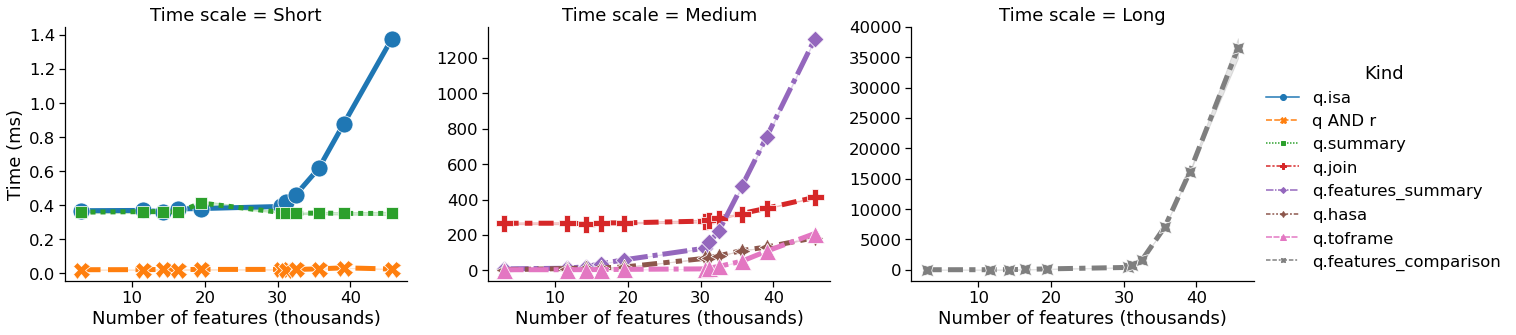

In [28]:
def figure_query_time_features(query_df: pd.DataFrame, x: str, output_file: str):
    with sns.plotting_context("notebook", font_scale=1.5):
        g = sns.relplot(x=x, y='Time (ms)', hue="Kind", style="Kind",
                        ci="sd", kind="line",
                        data=query_df, markers=True, estimator='mean', col="Time scale",
                        height=5, aspect=1.2, linewidth=5, markersize=17, err_kws={"alpha": 0.2},
                        facet_kws={'sharey': False, 'sharex': True})
        plt.savefig(output_file)
        
        return g
    
figure_query_time_features(query_df=query_df, x='Number of features (thousands)',
                           output_file='figures/query-api-runtime-features.pdf')

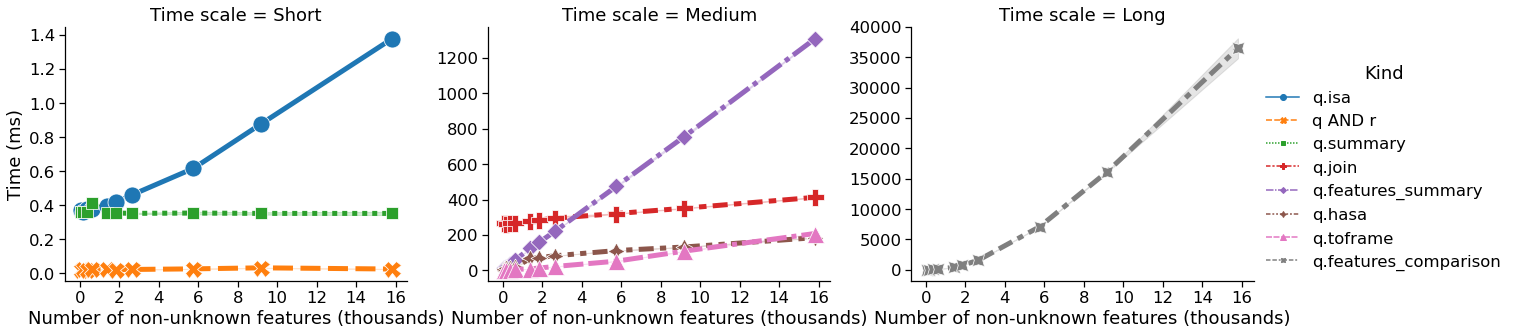

In [29]:
figure_query_time_features(query_df=query_df, x='Number of non-unknown features (thousands)',
                           output_file='figures/query-api-runtime-features-no-unknown.pdf')

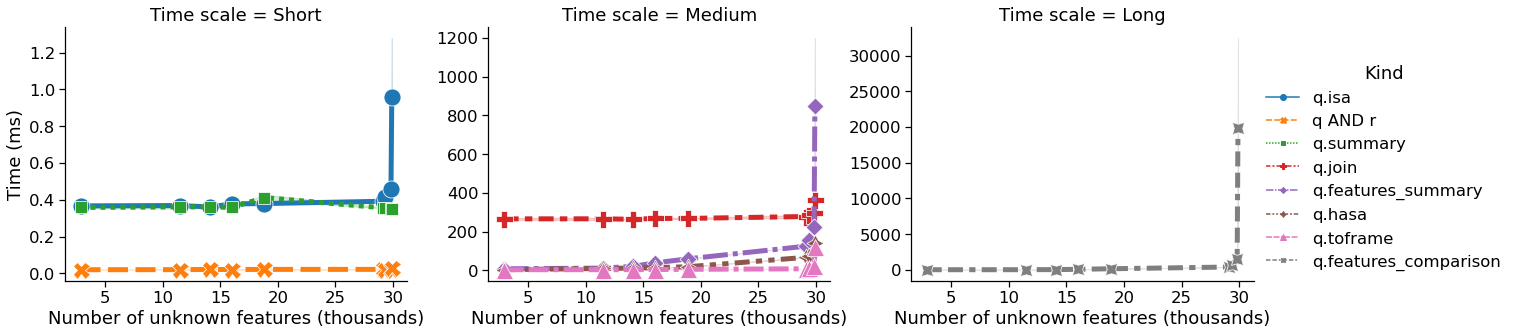

In [30]:
figure_query_time_features(query_df=query_df, x='Number of unknown features (thousands)',
                           output_file='figures/query-api-runtime-features-unknown.pdf')

#### 3.1.3.1. Features to number of samples

In [31]:
tmp_df = query_df[['Number samples',
                              'Number features (no unknown)',
                              'Number features (unknown)',
                              'Number features (all)']].groupby('Number samples').agg(
    {'Number features (no unknown)': 'first',
     'Number features (unknown)': 'first',
     'Number features (all)': 'first'}).reset_index()

sample_feature_df = pd.melt(tmp_df, id_vars=['Number samples'],
                            value_vars=['Number features (no unknown)',
                                        'Number features (unknown)',
                                        'Number features (all)'])
sample_feature_df = sample_feature_df.rename({'variable': 'Feature type', 'value': 'Count'}, axis='columns')
sample_feature_df.loc[sample_feature_df['Feature type'] == 'Number features (no unknown)',
                      'Feature type'] = 'No unknown'
sample_feature_df.loc[sample_feature_df['Feature type'] == 'Number features (unknown)',
                      'Feature type'] = 'Unknown'
sample_feature_df.loc[sample_feature_df['Feature type'] == 'Number features (all)',
                      'Feature type'] = 'All (No unknown + Unknown)'
sample_feature_df = sample_feature_df.sort_values('Feature type')

sample_feature_df

,Number samples,Feature type,Count
32,20000,All (No unknown + Unknown),45709
30,5000,All (No unknown + Unknown),35663
29,2000,All (No unknown + Unknown),32489
28,1000,All (No unknown + Unknown),31190
27,500,All (No unknown + Unknown),30534
26,200,All (No unknown + Unknown),19477
25,100,All (No unknown + Unknown),16351
24,50,All (No unknown + Unknown),14275
23,20,All (No unknown + Unknown),11560
22,10,All (No unknown + Unknown),2900


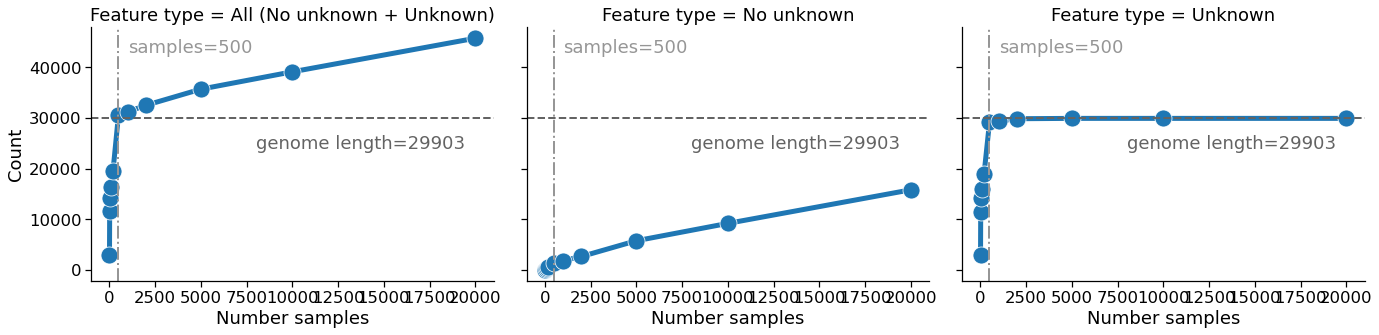

In [32]:
with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.relplot(x='Number samples', y='Count', col='Feature type',
                    kind="line",
                    data=sample_feature_df, marker='o',
                    height=5, aspect=1.3, linewidth=5, markersize=17, err_kws={"alpha": 0.2},
                    facet_kws={'sharey': True, 'sharex': True})
    
    for ax in g.axes.flat:
        samples = 500
        
#         block_color = 'lightgray'
#         ylim = ax.get_ylim()
#         ylen = ylim[1] - ylim[0]
#         xlim = ax.get_xlim()
#         xlen = xlim[1] - xlim[0]
#         reference_len_prop = (reference_length - ylim[0]) / ylen
        
#         if ax.title.get_text() in ["Feature type = All (No unknown + Unknown)"]:
#             ax.axvspan(xmin=samples, xmax=xlim[1], ymin=reference_len_prop, ymax=1, color=block_color, alpha=0.2)
#             ax.axvspan(xmin=xlim[0], xmax=samples, ymin=0, ymax=reference_len_prop, color=block_color, alpha=0.2)
#         elif ax.title.get_text() in ["Feature type = Unknown"]:
#             ax.axvspan(xmin=xlim[0], xmax=samples, ymin=0, ymax=reference_len_prop, color=block_color, alpha=0.2)
#         elif ax.title.get_text() in ["Feature type = No unknown"]:
#             ax.axvspan(xmin=samples, xmax=xlim[1], ymin=0, ymax=reference_len_prop, color=block_color, alpha=0.2)
        
        ax.axvline(samples, color='#969696', ls='-.', lw=2)
        xpos = samples * 2
        ypos = 43000
        ax.text(xpos, ypos, f'samples={samples}', fontdict={'size': 18, 'color': '#969696'})

        ax.axhline(reference_length, color='#636363', ls='--', lw=2)
        ylim = ax.get_ylim()
        ypos = reference_length - reference_length * 0.2
        xpos = 8000
        ax.text(xpos, ypos, f'genome length={reference_length}', fontdict={'size': 18, 'color': '#636363'})
    
    plt.savefig('figures/query-samples-features.pdf')

### 3.1.4. Runtime vs. number of features (sql_batch=8192)

In [33]:
query_sql_batch_df = load_query_df(query_api_file_name='sql-batch-query-api.tsv')
query_sql_batch_df.head(5)

,Name,Kind,Number samples,Number features (no unknown),Number features (all),Number executions,Iteration,Time (ms),Samples,Number features (unknown),Number of features (thousands),Number of non-unknown features (thousands),Number of unknown features (thousands),Time scale
600,case-500,q.isa,500,1401,30534,1000,1,0.382693,500,29133,30.534,1.401,29.133,Short
616,case-500,q AND r,500,1401,30534,10000,7,0.021354,500,29133,30.534,1.401,29.133,Short
638,case-500,q.summary,500,1401,30534,1000,9,0.367542,500,29133,30.534,1.401,29.133,Short
637,case-500,q.summary,500,1401,30534,1000,8,0.353892,500,29133,30.534,1.401,29.133,Short
636,case-500,q.summary,500,1401,30534,1000,7,0.348071,500,29133,30.534,1.401,29.133,Short


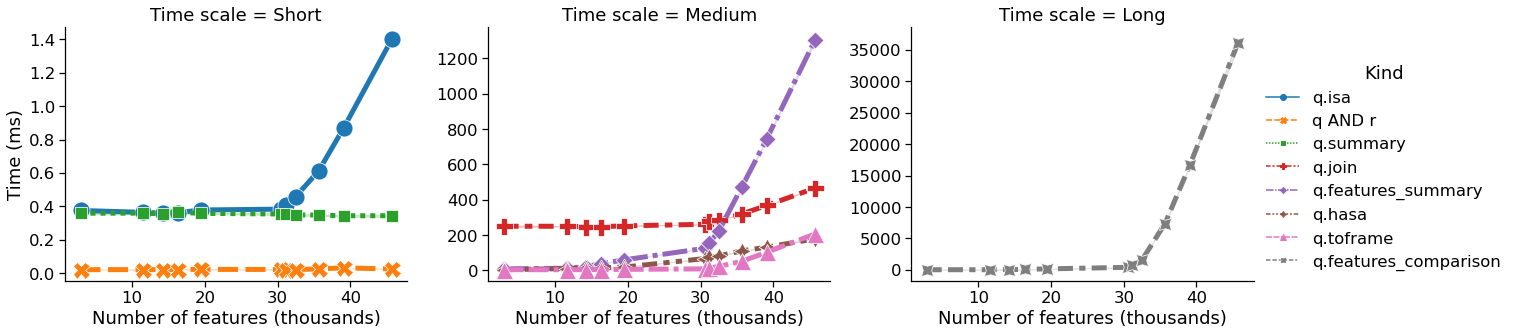

In [34]:
figure_query_time_features(query_df=query_sql_batch_df, x='Number of features (thousands)',
                           output_file='figures/query-api-sql-batch-runtime-features.pdf')

In [35]:
# query_mean_sql_batch_df = query_sql_batch_df.groupby(['Name', 'Kind']).agg({'Time (ms)': ['mean', 'std', 'count'],
#                                                         'Number features (all)': ['mean', 'std']})
# query_mean_sql_batch_df.loc[['case-2000', 'case-5000', 'case-10000', 'case-20000']]

## 3.2. Querying CLI

In [36]:
query_paths_cli = [x / 'query-cli.tsv' for x in cases_paths]
query_paths_cli = [x for x in query_paths_cli if x.exists()]
query_cli_df = read_all_df(query_paths_cli)
query_cli_df['Samples'] = query_cli_df['Name'].str.extract(r'^case-(\d+)').astype(int)
query_cli_df['Time (ms)'] = query_cli_df['Runtime'].apply(lambda x: x * 1000)
query_cli_df['Memory (MB)'] = query_cli_df['Memory (max)'].apply(lambda x: x / (1024**2))
query_cli_df['Number of features (thousands)'] = query_cli_df['Number features (all)'] / 1000
query_cli_df['Number of unknown features (thousands)'] = (query_cli_df['Number features (all)'] - \
                                                          query_cli_df['Number features (no unknown)']) / 1000

# Remove isin queries to ignore queries involving a tree
query_cli_df = query_cli_df[~query_cli_df['Kind'].str.contains('isin')]

query_cli_df.head(5)

,Name,Kind,Iteration,Number samples,Number features (no unknown),Number features (all),Runtime,Memory (max),Mmemory (max/process),Samples,Time (ms),Memory (MB),Number of features (thousands),Number of unknown features (thousands)
0,case-10,query hasa,1,10,44,2900,2.56,221945856.0,221945856.0,10,2560.0,211.664062,2.9,2.856
1,case-10,query hasa,2,10,44,2900,2.77,221782016.0,221782016.0,10,2770.0,211.507812,2.9,2.856
2,case-10,query hasa,3,10,44,2900,2.91,222380032.0,222380032.0,10,2910.0,212.078125,2.9,2.856
3,case-10,query hasa,4,10,44,2900,2.96,221696000.0,221696000.0,10,2960.0,211.425781,2.9,2.856
4,case-10,query hasa,5,10,44,2900,2.81,222433280.0,222433280.0,10,2810.0,212.128906,2.9,2.856


### 3.2.1. Compare runtime for single set of samples

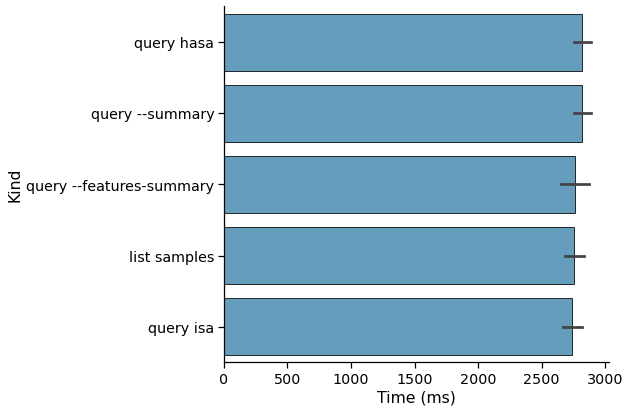

In [37]:
query_cli_samples = query_cli_df[query_cli_df['Samples'] == 100]
query_cli_samples = query_cli_samples.sort_values('Time (ms)', ascending=False)

with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.catplot(data=query_cli_samples, kind="bar",
                  y="Kind", x="Time (ms)", hue=None,
                  ci="sd", height=6, aspect=1.5, alpha=0.8,
                  color="#2b8cbe", edgecolor="black")
    plt.savefig('figures/query-cli-runtime-100.pdf')

#### 3.2.1.1. Compare runtime between CLI and API

In [38]:
qcli = query_cli_samples.loc[:, ['Name', 'Kind', 'Number samples', 'Time (ms)']]
qcli['Kind'] = qcli['Kind'].replace({
        'query isa': 'isa',
        'query hasa': 'hasa',
        'query isin': 'isin',
        'query --features-summary': 'features summary',
    })
qcli['Method'] = 'CLI'
qapi = query_samples.loc[:, ['Name', 'Kind', 'Number samples', 'Time (ms)']]
qapi['Kind'] = qapi['Kind'].replace({
        'q.isa': 'isa',
        'q.hasa': 'hasa',
        'q.isin': 'isin',
        'q.features_summary': 'features summary',
    })
qapi['Method'] = 'API'

q_cli_api = pd.concat([qcli, qapi])
q_cli_api = q_cli_api[q_cli_api['Kind'].isin(['isa', 'hasa', 'isin', 'features summary'])]
q_cli_api = q_cli_api.sort_values(['Time (ms)'])
q_cli_api.head(3)

,Name,Kind,Number samples,Time (ms),Method
386,case-100,isa,100,0.376643,API
387,case-100,isa,100,0.376760,API
383,case-100,isa,100,0.376942,API


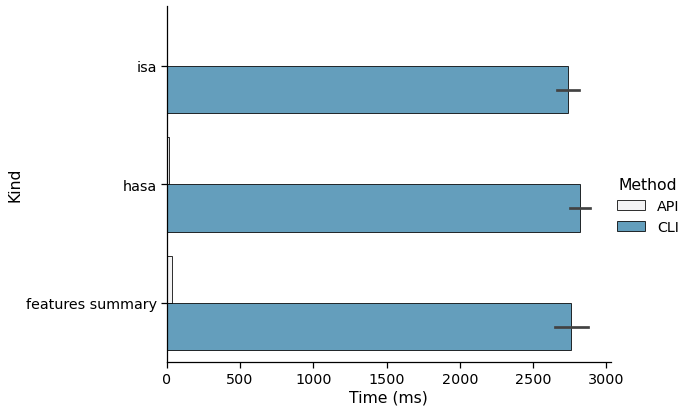

In [39]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.catplot(data=q_cli_api, kind="bar",
                  y="Kind", x="Time (ms)", hue='Method',
                  ci="sd", height=6, aspect=1.5, alpha=0.8,
                  color="#2b8cbe", edgecolor="black")
    plt.savefig('figures/query-cli-api-runtime-100.pdf')

### 3.2.2. Compare runtime to number of samples

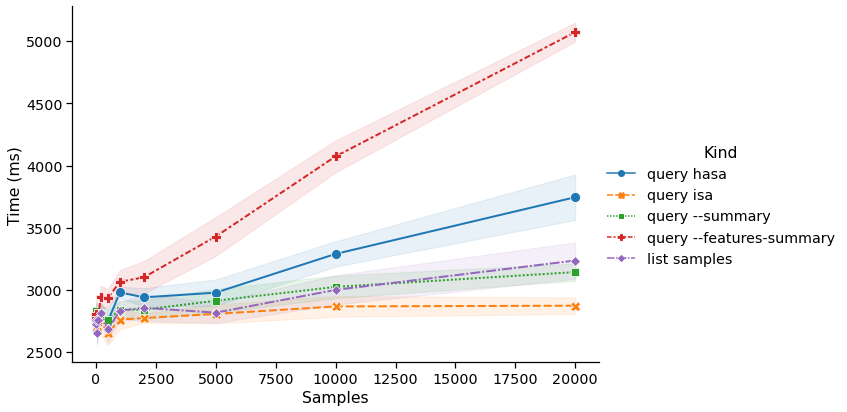

In [40]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Samples', y='Time (ms)', hue="Kind", ci="sd", kind="line",
                    data=query_cli_df, style="Kind", markers=True, estimator='mean',
                    height=6, aspect=1.5, linewidth=2, markersize=10, err_kws={"alpha": 0.1})
    plt.savefig('figures/query-cli-runtime.pdf')

#### 3.2.2.1. Mean/stdev

In [41]:
query_mean_df = query_cli_df.groupby(['Name', 'Kind']).agg({'Time (ms)': ['mean', 'std', 'count'],
                                                            'Number features (all)': ['mean', 'std']})
query_mean_df.loc[['case-10', 'case-20', 'case-2000', 'case-5000', 'case-10000', 'case-20000']]

Time (ms)                    \
                                         mean         std count   
Name       Kind                                                   
case-10    list samples                2730.0  104.243305    10   
           query --features-summary    2779.0   76.804224    10   
           query --summary             2765.0   76.048230    10   
           query hasa                  2765.0  119.559376    10   
           query isa                   2781.0   50.431472    10   
case-20    list samples                2760.0   79.162281    10   
           query --features-summary    2806.0  120.848850    10   
           query --summary             2830.0   71.492035    10   
           query hasa                  2750.0   76.157731    10   
           query isa                   2769.0   89.622666    10   
case-2000  list samples                2857.0  106.879995    10   
           query --features-summary    3102.0  130.622441    10   
           query --summary             2842.0   75.542483    10   
           query hasa                  2941.0   74.899933    10   
           query isa                   2775.0   38.658045    10   
case-5000  list samples                2818.0   81.622437    10   
           query --features-summary    3430.0  155.991453    10   
           query --summary             2914.0   95.008772    10   
           query hasa                  2979.0  105.561988    10   
           query isa                   2808.0   75.689424    10   
case-10000 list samples                3001.0  117.799264    10   
           query --features-summary    4074.0  128.858234    10   
           query --summary             3025.0   90.829511    10   
           query hasa                  3290.0  101.871379    10   
           query isa                   2868.0   82.972552    10   
case-20000 list samples                3237.0  145.910932    10   
           query --features-summary    5073.0   75.726115    10   
           query --summary             3144.0   69.633964    10   
           query hasa                  3746.0  182.708025    10   
           query isa                   2874.0   67.197884    10   

                                    Number features (all)       
                                                     mean  std  
Name       Kind                                                 
case-10    list samples                            2900.0  0.0  
           query --features-summary                2900.0  0.0  
           query --summary                         2900.0  0.0  
           query hasa                              2900.0  0.0  
           query isa                               2900.0  0.0  
case-20    list samples                           11560.0  0.0  
           query --features-summary               11560.0  0.0  
           query --summary                        11560.0  0.0  
           query hasa                             11560.0  0.0  
           query isa                              11560.0  0.0  
case-2000  list samples                           32489.0  0.0  
           query --features-summary               32489.0  0.0  
           query --summary                        32489.0  0.0  
           query hasa                             32489.0  0.0  
           query isa                              32489.0  0.0  
case-5000  list samples                           35663.0  0.0  
           query --features-summary               35663.0  0.0  
           query --summary                        35663.0  0.0  
           query hasa                             35663.0  0.0  
           query isa                              35663.0  0.0  
case-10000 list samples                           39089.0  0.0  
           query --features-summary               39089.0  0.0  
           query --summary                        39089.0  0.0  
           query hasa                             39089.0  0.0  
           query isa                              39089.0  0.0  
case

In [42]:
query_mean_df['Time (ms)', 'mean'].min()

2652.0

### 3.2.3. Compare peak memory to number of samples

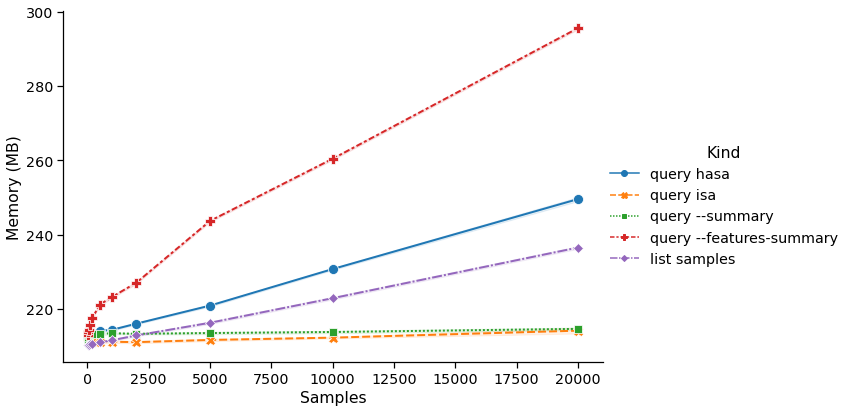

In [43]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Samples', y='Memory (MB)', hue="Kind", style="Kind", ci="sd", kind="line",
                    data=query_cli_df, markers=True, estimator='mean',
                    height=6, aspect=1.5, linewidth=2, markersize=10, err_kws={"alpha": 0.1})
    plt.savefig('figures/query-cli-memory.pdf')

#### 3.2.3.1. Mean/stddev

In [44]:
query_mean_df = query_cli_df.groupby(['Name', 'Kind']).agg({'Memory (MB)': ['mean', 'std', 'count'],
                                                            'Number features (all)': ['mean', 'std']})
query_mean_df.loc[['case-2000', 'case-5000', 'case-10000', 'case-20000']]

Memory (MB)                  \
                                           mean       std count   
Name       Kind                                                   
case-2000  list samples              212.872266  0.230701    10   
           query --features-summary  227.092187  0.286282    10   
           query --summary           213.315234  0.187093    10   
           query hasa                216.051172  0.199167    10   
           query isa                 211.065625  0.302043    10   
case-5000  list samples              216.283594  0.318227    10   
           query --features-summary  243.716016  0.285516    10   
           query --summary           213.515234  0.314767    10   
           query hasa                220.911719  0.274349    10   
           query isa                 211.656250  0.312451    10   
case-10000 list samples              222.901563  0.362867    10   
           query --features-summary  260.465625  0.318757    10   
           query --summary           213.798828  0.319232    10   
           query hasa                230.754297  0.259199    10   
           query isa                 212.276172  0.206363    10   
case-20000 list samples              236.548438  0.350356    10   
           query --features-summary  295.652734  0.334767    10   
           query --summary           214.640234  0.353148    10   
           query hasa                249.601953  0.551492    10   
           query isa                 214.158984  0.765412    10   

                                    Number features (all)       
                                                     mean  std  
Name       Kind                                                 
case-2000  list samples                           32489.0  0.0  
           query --features-summary               32489.0  0.0  
           query --summary                        32489.0  0.0  
           query hasa                             32489.0  0.0  
           query isa                              32489.0  0.0  
case-5000  list samples                           35663.0  0.0  
           query --features-summary               35663.0  0.0  
           query --summary                        35663.0  0.0  
           query hasa                             35663.0  0.0  
           query isa                              35663.0  0.0  
case-10000 list samples                           39089.0  0.0  
           query --features-summary               39089.0  0.0  
           query --summary                        39089.0  0.0  
           query hasa                             39089.0  0.0  
           query isa                              39089.0  0.0  
case-20000 list samples                           45709.0  0.0  
           query --features-summary               45709.0  0.0  
           query --summary                        45709.0  0.0  
           query hasa                             45709.0  0.0  
           query isa                              45709.0  0.0

### 3.2.4. Compare runtime to number of features

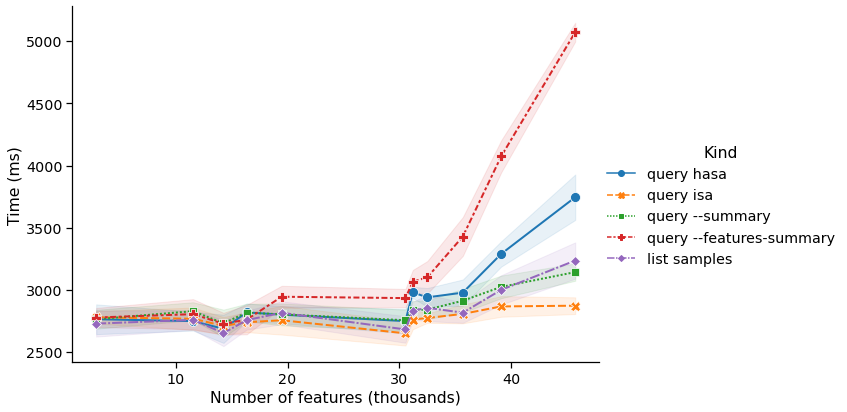

In [45]:
# with sns.plotting_context("notebook", font_scale=1.3):
#     g = sns.relplot(x='Number of features (thousands)', y='Time (ms)', col="Kind", ci="sd", kind="line",
#                     data=query_cli_df, marker="o", estimator='mean',
#                    facet_kws={'sharey': True, 'sharex': True}, col_wrap=3, height=5)
    
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Number of features (thousands)', y='Time (ms)', hue="Kind", ci="sd", kind="line",
                    data=query_cli_df, markers=True, estimator='mean', style="Kind",
                   height=6, aspect=1.5, linewidth=2, markersize=10, err_kws={"alpha": 0.1})
    plt.savefig('figures/query-cli-runtime-features.pdf')

### 3.2.5. Compare peak memory to number of features

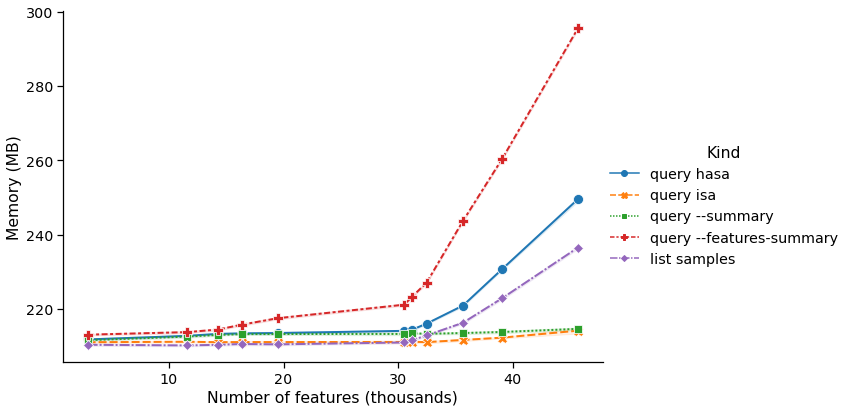

In [46]:
# with sns.plotting_context("notebook", font_scale=1.3):
#     g = sns.relplot(x='Number of features (thousands)', y='Memory (MB)', col="Kind", ci="sd", kind="line",
#                     data=query_cli_df, marker="o", estimator='mean',
#                    facet_kws={'sharey': True, 'sharex': True}, col_wrap=3, height=5)
    
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(x='Number of features (thousands)', y='Memory (MB)', hue="Kind", ci="sd", kind="line",
                    data=query_cli_df, markers=True, estimator='mean', style="Kind",
                   height=6, aspect=1.5, linewidth=2, markersize=10, err_kws={"alpha": 0.1})
    plt.savefig('figures/query-cli-memory-features.pdf')

# 4. Tree vs. clustering

## 4.1. Connect to index and metadata file

In [47]:
import genomics_data_index.api as gdi

number_samples = 500
min_samples_cluster = 2

clustering_index = cases_root_dir / f'case-{number_samples}' / 'index'
db = gdi.GenomicsDataIndex.connect(clustering_index)
db

<GenomicsDataIndex(samples=500)>

In [48]:
import pandas as pd

metadata_df = pd.read_csv(metadata_file, sep='\t')
metadata_df.head(2)

,strain,virus,gisaid_epi_isl,genbank_accession,sra_accession,date,region,country,division,location,...,ambiguity_score,scorpio_call,scorpio_support,scorpio_conflict,version,pangolin_version,pangoLEARN_version,pango_version,status,note
0,OU420663,ncov,?,OU420663,ERR5939958,2020,Europe,United Kingdom,England,NaN,...,1.000000,Alpha (B.1.1.7-like),1.0,0.0,PLEARN-v1.2.127,3.1.20,2022-02-28,v1.2.127,passed_qc,scorpio call: Alt alleles 23; Ref alleles 0; A...
1,USA/NY-CUIMC-NP-3606/2020,ncov,?,MZ702266,NaN,2020-12-02,North America,USA,New York,New York City,...,0.951273,NaN,NaN,NaN,PLEARN-v1.2.127,3.1.20,2022-02-28,v1.2.127,passed_qc,NaN


In [49]:
metadata_df.columns

Index(['strain', 'virus', 'gisaid_epi_isl', 'genbank_accession',
       'sra_accession', 'date', 'region', 'country', 'division', 'location',
       'region_exposure', 'country_exposure', 'division_exposure', 'segment',
       'length', 'host', 'age', 'sex', 'Nextstrain_clade', 'pango_lineage',
       'GISAID_clade', 'originating_lab', 'submitting_lab', 'authors', 'url',
       'title', 'paper_url', 'date_submitted', 'sampling_strategy',
       'missing_data', 'divergence', 'nonACGTN', 'rare_mutations',
       'snp_clusters', 'QC_missing_data', 'QC_mixed_sites',
       'QC_rare_mutations', 'QC_snp_clusters', 'clock_deviation',
       'missing_data_percent', 'taxon', 'lineage', 'conflict',
       'ambiguity_score', 'scorpio_call', 'scorpio_support',
       'scorpio_conflict', 'version', 'pangolin_version', 'pangoLEARN_version',
       'pango_version', 'status', 'note'],
      dtype='object')

In [50]:
metadata_df[metadata_df['lineage'].str.match('^[^.][^.]')]['lineage'].value_counts()

AY.4      11077
AY.44      1104
AY.5        753
None        726
AY.103      674
          ...  
AY.5.1        1
AA.4          1
AE.8          1
AY.7.2        1
AY.17         1
Name: lineage, Length: 156, dtype: int64

In [51]:
metadata_df['pangolin_version'].value_counts()

3.1.20    100000
Name: pangolin_version, dtype: int64

In [52]:
metadata_df['pangoLEARN_version'].value_counts()

2022-02-28    100000
Name: pangoLEARN_version, dtype: int64

In [53]:
metadata_df['version'].value_counts()

PLEARN-v1.2.127    69441
PANGO-v1.2.127     30559
Name: version, dtype: int64

### 4.1.1. Subset dataframe to only those found on tree

In [54]:
q = db.samples_query(reference_name='NC_045512', universe='mutations')
metadata_subset_df = metadata_df[metadata_df['strain'].isin(q.tolist())]
metadata_subset_df

,strain,virus,gisaid_epi_isl,genbank_accession,sra_accession,date,region,country,division,location,...,ambiguity_score,scorpio_call,scorpio_support,scorpio_conflict,version,pangolin_version,pangoLEARN_version,pango_version,status,note
0,OU420663,ncov,?,OU420663,ERR5939958,2020,Europe,United Kingdom,England,NaN,...,1.000000,Alpha (B.1.1.7-like),1.0000,0.0000,PLEARN-v1.2.127,3.1.20,2022-02-28,v1.2.127,passed_qc,scorpio call: Alt alleles 23; Ref alleles 0; A...
198,LR898737,ncov,?,LR898737,NaN,2020,Europe,Switzerland,Zürich,NaN,...,0.999793,NaN,NaN,NaN,PLEARN-v1.2.127,3.1.20,2022-02-28,v1.2.127,passed_qc,NaN
880,AUS/VIC16710/2020,ncov,?,MW276897,SRR13129475,2020,Oceania,Australia,Victoria,NaN,...,0.989308,NaN,NaN,NaN,PLEARN-v1.2.127,3.1.20,2022-02-28,v1.2.127,passed_qc,NaN
893,LR882821,ncov,EPI_ISL_560422,LR882821,NaN,2020,Europe,Switzerland,Aargau,NaN,...,NaN,NaN,NaN,NaN,PANGO-v1.2.127,3.1.20,2022-02-28,v1.2.127,passed_qc,Assigned from designation hash.
1520,LR882111,ncov,?,LR882111,NaN,2020,Europe,Switzerland,Basel-Land,NaN,...,0.997921,NaN,NaN,NaN,PLEARN-v1.2.127,3.1.20,2022-02-28,v1.2.127,passed_qc,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97490,LR882312,ncov,EPI_ISL_512041,LR882312,NaN,2020,Europe,Switzerland,Graubünden,NaN,...,0.937872,NaN,NaN,NaN,PLEARN-v1.2.127,3.1.20,2022-02-28,v1.2.127,passed_qc,NaN
97691,LR881880,ncov,EPI_ISL_535587,LR881880,NaN,2020,Europe,Switzerland,Basel-Stadt,NaN,...,NaN,NaN,NaN,NaN,PANGO-v1.2.127,3.1.20,2022-02-28,v1.2.127,passed_qc,Assigned from designation hash.
98241,OU396799,ncov,?,OU396799,ERR5937934,2020,Europe,United Kingdom,England,NaN,...,1.000000,Alpha (B.1.1.7-like),0.9565,0.0435,PLEARN-v1.2.127,3.1.20,2022-02-28,v1.2.127,passed_qc,scorpio call: Alt alleles 22; Ref alleles 1; A...
99816,Switzerland/100793/2020,ncov,?,LR824302,NaN,2020,Europe,Switzerland,Basel-Land,NaN,...,0.640823,NaN,NaN,NaN,PLEARN-v1.2.127,3.1.20,2022-02-28,v1.2.127,passed_qc,NaN


In [55]:
metadata_subset_df['status'].value_counts()

passed_qc    493
fail           7
Name: status, dtype: int64

In [56]:
metadata_subset_df[metadata_subset_df['lineage'] == 'None']['status'].value_counts()

fail    7
Name: status, dtype: int64

In [57]:
no_lineage_df = metadata_subset_df[metadata_subset_df['lineage'] == 'None'][['strain', 'lineage', 'missing_data_percent',
                                                             'QC_missing_data', 'QC_mixed_sites',
                                                            'nonACGTN', 'length']]
no_lineage_samples = no_lineage_df['strain'].tolist()
print(no_lineage_samples)
no_lineage_df

['OU487653', 'Japan/DP0700/2020', 'OU395174', 'OU489002', 'OU421540', 'OU419825', 'OB998205']


,strain,lineage,missing_data_percent,QC_missing_data,QC_mixed_sites,nonACGTN,length
13003,OU487653,None,36.678594,bad,good,0.0,29896
44186,Japan/DP0700/2020,None,0.000000,good,good,0.0,22839
54883,OU395174,None,44.985453,bad,good,1.0,29887
66914,OU489002,None,44.878440,bad,good,1.0,29896
78627,OU421540,None,47.279537,bad,mediocre,7.0,29887
83796,OU419825,None,49.339531,bad,good,0.0,29884
88476,OB998205,None,42.216500,bad,good,0.0,29884


### 4.1.2. Expand lineages so they are hierarchical

Some lineages have 2-character top-level codes which are aliases for other lineages (e.g., `AY` is an alias for `B.1.617.2`, https://cov-lineages.org/lineage_list.html). In order for my cluster comparison code to work I need to expand these lineages back to their long-form version. I am doing this here.

Note: I'm only expanding lineages I've observed in my final tree. In particular:

`AY` is an alias for `B.1.617.2` while `AV` is an alias for `B.1.1.482` (https://cov-lineages.org/lineage_list.html).

In [58]:
import re

metadata_expaneded_lineages_df = metadata_subset_df.copy()
metadata_expaneded_lineages_df['lineage'] = metadata_expaneded_lineages_df['lineage'].apply(lambda x: re.sub(r'^AY\.', r'B.1.617.2.', x))
metadata_expaneded_lineages_df['lineage'] = metadata_expaneded_lineages_df['lineage'].apply(lambda x: re.sub(r'^AV\.', r'B.1.1.482.', x))
metadata_expaneded_lineages_df['lineage'] = metadata_expaneded_lineages_df['lineage'].apply(lambda x: re.sub(r'^C\.', r'B.1.1.1.1.', x))
metadata_expaneded_lineages_df['lineage'] = metadata_expaneded_lineages_df['lineage'].apply(lambda x: re.sub(r'^D\.', r'B.1.1.25.', x))
metadata_expaneded_lineages_df['lineage'] = metadata_expaneded_lineages_df['lineage'].apply(lambda x: re.sub(r'^W\.', r'B.1.177.53.', x))
metadata_expaneded_lineages_df['lineage'] = metadata_expaneded_lineages_df['lineage'].apply(lambda x: re.sub(r'^Q\.', r'B.1.1.7.', x))

# Print any remaining single-letter (after A and B) and mutli-letter codes
# That were not expanded from above commands
metadata_expaneded_lineages_df[
    metadata_expaneded_lineages_df['lineage'].str.match(
        '^([^AB]\.)|([A-Z][A-Z]+\.)')]['lineage'].value_counts()

Series([], Name: lineage, dtype: int64)

In [59]:
metadata_expaneded_lineages_df[metadata_expaneded_lineages_df['lineage'].str.match('B.1.617.2') | 
                              metadata_expaneded_lineages_df['lineage'].str.match('B.1.1.482')]['lineage'].value_counts()

B.1.617.2.4       62
B.1.617.2         12
B.1.1.482.1        5
B.1.617.2.120      2
B.1.617.2.122      2
B.1.617.2.5        1
B.1.617.2.4.7      1
B.1.617.2.46.5     1
Name: lineage, dtype: int64

## 4.2. Initiate query

In [60]:
q = db.samples_query(reference_name='NC_045512', universe='mutations').set_outgroup('NC_045512')\
      .join(metadata_expaneded_lineages_df, sample_names_column='strain')
q

<MutationTreeSamplesQuery[selected=100% (500/500) samples, unknown=0% (0/500) samples]>

In [61]:
# Remove those samples with lineage None
qminus_none = (~q.isin(no_lineage_samples)).prune()
qminus_none

<MutationTreeSamplesQuery[selected=99% (493/500) samples, unknown=0% (0/500) samples]>

## 4.3. Look over lineages in tree

In [62]:
samples_examined_df = q.toframe()
samples_examined_df['lineage'].value_counts()

B.1.1.7           121
B.1.617.2.4        62
B.1                45
B.1.1.25.2         36
B                  24
                 ... 
B.12                1
B.1.1.47            1
B.1.369             1
B.1.617.2.4.7       1
B.1.617.2.46.5      1
Name: lineage, Length: 70, dtype: int64

In [63]:
samples_examined_df[samples_examined_df['lineage'].str.match('^[^.][^.]')]['lineage'].value_counts()

None    7
Name: lineage, dtype: int64

## 4.4. Cluster scoring (ML tree)

In [64]:
max_lineage_depth = max(map(lambda x: x.count('.') + 1, samples_examined_df['lineage'].value_counts().index.tolist()))
max_lineage_depth

6

In [65]:
import re

lineage_level_group_funcs = {
    0: lambda x: re.sub(r'^([^.]*)\..*', r'\1', x),
    1: lambda x: re.sub(r'^([^.]*\.[^.]+)\..*', r'\1', x),
    2: lambda x: re.sub(r'^([^.]*\.[^.]+\.[^.]+)\..*', r'\1', x),
    3: lambda x: re.sub(r'^([^.]*\.[^.]+\.[^.]+\.[^.]+)\..*', r'\1', x),
    4: lambda x: re.sub(r'^([^.]*\.[^.]+\.[^.]+\.[^.]+\.[^.]+)\..*', r'\1', x),
    5: lambda x: re.sub(r'^([^.]*\.[^.]+\.[^.]+\.[^.]+\.[^.]+\.[^.]+)\..*', r'\1', x),
    6: lambda x: re.sub(r'^([^.]*\.[^.]+\.[^.]+\.[^.]+\.[^.]+\.[^.]+\.[^.]+)\..*', r'\1', x),
}

test_lineage = 'A.11.22.3.4.5.6'
for i in range(max_lineage_depth + 1):
    print(f'Level {i}: {lineage_level_group_funcs[i](test_lineage)} [{test_lineage}]')

Level 0: A [A.11.22.3.4.5.6]
Level 1: A.11 [A.11.22.3.4.5.6]
Level 2: A.11.22 [A.11.22.3.4.5.6]
Level 3: A.11.22.3 [A.11.22.3.4.5.6]
Level 4: A.11.22.3.4 [A.11.22.3.4.5.6]
Level 5: A.11.22.3.4.5 [A.11.22.3.4.5.6]
Level 6: A.11.22.3.4.5.6 [A.11.22.3.4.5.6]


In [66]:
from genomics_data_index.api.query.impl.ClusterScorer import ClusterScorer

def get_scores_at_lineage_level(scorer: ClusterScorer, level: int, score_label: str) -> pd.DataFrame:
    scores = scorer.score_groupby(groupby_column='lineage', min_samples_count=min_samples_cluster,
                                    groupby_func=lineage_level_group_funcs[level])
    scores = scores.rename({'Score': score_label}, axis='columns')
    scores = scores[scores.index.str.count('\.') == level]
    
    return scores

def get_scores_grouped_by_lineage_levels(scorer: ClusterScorer, score_label: str,
                                         max_level: int) -> pd.DataFrame:
    level_dfs = []
    for level in range(max_level):
        level_dfs.append(get_scores_at_lineage_level(scorer=scorer, score_label=score_label, level=level))
    return pd.concat(level_dfs)

In [67]:
scores_ml = get_scores_grouped_by_lineage_levels(scorer=ClusterScorer(q), score_label='Score (ML)',
                                                 max_level=max_lineage_depth)
scores_ml

,Score (ML),Sample Count
lineage,,
A,0.036000,18
B,0.950000,475
None,0.014000,7
A.1,1.000000,12
B.1,0.984340,440
B.3,1.000000,3
B.4,1.000000,2
B.43,1.000000,3
B.1.1,0.982684,227


In [68]:
scores_ml['Score (ML)'].describe()

count    41.000000
mean      0.909600
std       0.253218
min       0.014000
25%       0.975904
50%       1.000000
75%       1.000000
max       1.000000
Name: Score (ML), dtype: float64

In [69]:
scores_ml_minus_none = get_scores_grouped_by_lineage_levels(scorer=ClusterScorer(qminus_none),
                                                            score_label='Score (ML minus None)',
                                                            max_level=max_lineage_depth)
scores_ml_minus_none

,Score (ML minus None),Sample Count
lineage,,
A,0.036511,18
B,0.963489,475
A.1,1.000000,12
B.1,0.997732,440
B.3,1.000000,3
B.4,1.000000,2
B.43,1.000000,3
B.1.1,1.000000,227
B.1.146,1.000000,3


In [70]:
scores_ml_minus_none['Score (ML minus None)'].describe()

count    40.000000
mean      0.935736
std       0.211821
min       0.036511
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: Score (ML minus None), dtype: float64

## 4.5. Cluster scoring (kmer trees)

### 4.5.1. Build and score 31-mer tree

In [71]:
from ete3 import Tree, ClusterTree

# Used due to a bug in the software which uses the original filenames as names in the tree instead
# of the sample names. This can be removed when the bug is fixed.
def fix_kmer_tree_names(tree: Tree) -> Tree:
    newick_str = tree.write()
    newick_fixed = newick_str.replace('__','/')
            
    return ClusterTree(newick_fixed)

In [72]:
import time

q31 = db.samples_query()
start = time.time()
q31 = q31.build_tree(kind='kmer', kmer_size=31)
end = time.time()
q31 = q31.join(metadata_expaneded_lineages_df, sample_names_column='strain')
q31._tree = fix_kmer_tree_names(q31.tree)
print(f'Took {end - start:0.2f} seconds to build a kmer tree for {len(q31)} samples')
q31

Took 1.66 seconds to build a kmer tree for 500 samples


<KmerTreeSamplesQuery[selected=100% (500/500) samples, unknown=0% (0/500) samples]>

In [73]:
score_kmer_31 = get_scores_grouped_by_lineage_levels(scorer=ClusterScorer(q31), score_label='Score (kmer=31)',
                                                 max_level=max_lineage_depth)
score_kmer_31

,Score (kmer=31),Sample Count
lineage,,
A,0.036961,18
B,0.957661,475
None,0.014000,7
A.1,0.024641,12
B.1,0.887097,440
B.3,0.010791,3
B.4,0.142857,2
B.43,0.008746,3
B.1.1,0.463265,227


### 4.5.2. Build and score 51-mer tree

In [74]:
import numpy as np

def build_time_kmer_tree(iterations: int):
    q51_tree = None
    tree_times = []
    for i in range(iterations):
        q51 = db.samples_query()
        start = time.time()
        q51_tree = q51.build_tree(kind='kmer', kmer_size=51)
        end = time.time()
        tree_times.append(end - start)
    q51_tree = q51_tree.join(metadata_expaneded_lineages_df, sample_names_column='strain')
    q51_tree._tree = fix_kmer_tree_names(q51_tree.tree)
    
    return q51_tree, tree_times

q51, tree_times = build_time_kmer_tree(iterations=3)
mean_time = np.mean(tree_times)
stddev_time = np.std(tree_times)
print(f'Took {mean_time} +- {stddev_time} seconds to build a kmer tree for {len(q31)} samples')
q51

Took 1.7214737733205159 +- 0.056325810939212254 seconds to build a kmer tree for 500 samples


<KmerTreeSamplesQuery[selected=100% (500/500) samples, unknown=0% (0/500) samples]>

In [75]:
score_kmer_51 = get_scores_grouped_by_lineage_levels(scorer=ClusterScorer(q51), score_label='Score (kmer=51)',
                                                 max_level=max_lineage_depth)
score_kmer_51

,Score (kmer=51),Sample Count
lineage,,
A,0.037500,18
B,0.953815,475
None,0.014000,7
A.1,0.025000,12
B.1,0.883534,440
B.3,0.016949,3
B.4,0.011299,2
B.43,0.008043,3
B.1.1,0.457661,227


### 4.5.2. Build and score 71-mer tree

In [76]:
q71 = db.samples_query()
start = time.time()
q71 = q71.build_tree(kind='kmer', kmer_size=71)
end = time.time()
q71 = q71.join(metadata_expaneded_lineages_df, sample_names_column='strain')
q71._tree = fix_kmer_tree_names(q71.tree)
print(f'Took {end - start:0.2f} seconds to build a kmer tree for {len(q31)} samples')
q71

Took 1.65 seconds to build a kmer tree for 500 samples


<KmerTreeSamplesQuery[selected=100% (500/500) samples, unknown=0% (0/500) samples]>

In [77]:
score_kmer_71 = get_scores_grouped_by_lineage_levels(scorer=ClusterScorer(q71), score_label='Score (kmer=71)',
                                                 max_level=max_lineage_depth)
score_kmer_71

,Score (kmer=71),Sample Count
lineage,,
A,0.036810,18
B,0.959596,475
None,0.014000,7
A.1,0.024540,12
B.1,0.888889,440
B.3,0.011765,3
B.4,0.019048,2
B.43,0.028302,3
B.1.1,0.459514,227


## 4.6. Plot cluster scores

In [78]:
sns.cubehelix_palette(n_colors=5, start=0, rot=2, dark=0.3, light=0.7).as_hex()

['#cbad90', '#c182a8', '#7d78b2', '#3b7975', '#395c29']

In [79]:
from typing import Callable

def apply_colors_to_level(df: pd.DataFrame, color_func: Callable[[int], List[str]], level: int = 0) -> pd.DataFrame:
    df = df.copy()
    number_colors = len(scores_df[scores_df['lineage level'] == level])
    colors = color_func(number_colors)
    df.loc[df['lineage level'] == level, 'color'] = colors
    return df

def apply_colors_to_df(df: pd.DataFrame, color_func: Callable[[int], List[str]]) -> pd.DataFrame:
    df = df.copy()
    number_colors = len(scores_df)
    colors = color_func(number_colors)
    df['color'] = colors
    return df

def create_color_column(df: pd.DataFrame, score_suffix: str) -> pd.DataFrame:
    df = df.copy()
    
    high_color = '#33a02c'
    low_color = '#b2df8a'
    
    score_col = f'Score {score_suffix}'
    color_col = f'Color {score_suffix}'
    df[color_col] = low_color
    df.loc[df[score_col] > 0.9, color_col] = high_color
    
    return df

scores_df = scores_ml.copy()
for other_df in [score_kmer_31, score_kmer_51, score_kmer_71]:
    other_df = other_df.drop(['Sample Count'], axis='columns')
    scores_df = scores_df.merge(other_df, left_index=True, right_index=True)
scores_df = scores_df.reset_index()
scores_df['lineage level'] = scores_df['lineage'].str.count('\.')

# Make those with 'None' lineage be at level -1
scores_df.loc[scores_df['lineage'] == 'None', 'lineage level'] = -1

for level in range(max_lineage_depth):
    scores_df[f'level {level}'] = scores_df['lineage'].apply(lineage_level_group_funcs[level])
    
scores_df['level -1'] = 0
scores_df.loc[scores_df['lineage'] == 'None', 'level -1'] = -1

# scores_df = scores_df.sort_values(['lineage level', 'lineage']).reset_index(drop=True)
scores_df = scores_df.sort_values(['level -1', 'level 0', 'Sample Count',
                                   'level 1', 'level 2', 'level 3', 'level 4', 'level 5'],
                                 ascending=[True, True, False, True, True, True, True, True])
scores_df = scores_df.reset_index(drop=True)

# Add color based on score
scores_df = create_color_column(scores_df, score_suffix = '(ML)')
scores_df = create_color_column(scores_df, score_suffix = '(kmer=31)')
scores_df = create_color_column(scores_df, score_suffix = '(kmer=51)')
scores_df = create_color_column(scores_df, score_suffix = '(kmer=71)')

# Add single list of colors
# scores_df = apply_colors_to_df(
#     scores_df,
#     color_func=lambda n: list(
#         sns.cubehelix_palette(n_colors=n, start=0, rot=2, dark=0.3, light=0.7).as_hex())
# )

# Add colors to each category
# for level in range(max_lineage_depth):
#     scores_df = apply_colors_to_level(
#         scores_df,
#         color_func=lambda n: list(
#             sns.cubehelix_palette(n_colors=n, start=0.7 * level, rot=0, dark=0.3, light=0.7).as_hex()),
#         level=level)

# Add color for None
scores_df.loc[scores_df['lineage'] == 'None', 'color'] = 'black'
    
scores_df = scores_df.reset_index().rename({'index': 'order'}, axis='columns')
scores_df['order'] = scores_df['order'] + 1
scores_df['Order label'] = '(' + scores_df['order'].astype(str) + ')'

scores_df['Label (ML)'] = scores_df['Order label'] + ' ' + scores_df['lineage'] \
                              + ' (n=' + scores_df['Sample Count'].astype(str) \
                              + ', score=' + scores_df['Score (ML)'].apply(lambda x: f'{x:0.2f}') + ')'

for kmer in ['31', '51', '71']:
    scores_df[f'Label (kmer={kmer})'] = scores_df['Order label'] + ' ' + scores_df['lineage'] \
                                  + ' (n=' + scores_df['Sample Count'].astype(str) \
                                  + ', score=' + scores_df[f'Score (kmer={kmer})'].apply(lambda x: f'{x:0.2f}') + ')'
scores_df

,order,lineage,Score (ML),Sample Count,Score (kmer=31),Score (kmer=51),Score (kmer=71),lineage level,level 0,level 1,...,Color (ML),Color (kmer=31),Color (kmer=51),Color (kmer=71),color,Order label,Label (ML),Label (kmer=31),Label (kmer=51),Label (kmer=71)
0,1,None,0.014000,7,0.014000,0.014000,0.014000,-1,None,None,...,#b2df8a,#b2df8a,#b2df8a,#b2df8a,black,(1),"(1) None (n=7, score=0.01)","(1) None (n=7, score=0.01)","(1) None (n=7, score=0.01)","(1) None (n=7, score=0.01)"
1,2,A,0.036000,18,0.036961,0.037500,0.036810,0,A,A,...,#b2df8a,#b2df8a,#b2df8a,#b2df8a,NaN,(2),"(2) A (n=18, score=0.04)","(2) A (n=18, score=0.04)","(2) A (n=18, score=0.04)","(2) A (n=18, score=0.04)"
2,3,A.1,1.000000,12,0.024641,0.025000,0.024540,1,A,A.1,...,#33a02c,#b2df8a,#b2df8a,#b2df8a,NaN,(3),"(3) A.1 (n=12, score=1.00)","(3) A.1 (n=12, score=0.02)","(3) A.1 (n=12, score=0.03)","(3) A.1 (n=12, score=0.02)"
3,4,B,0.950000,475,0.957661,0.953815,0.959596,0,B,B,...,#33a02c,#33a02c,#33a02c,#33a02c,NaN,(4),"(4) B (n=475, score=0.95)","(4) B (n=475, score=0.96)","(4) B (n=475, score=0.95)","(4) B (n=475, score=0.96)"
4,5,B.1,0.984340,440,0.887097,0.883534,0.888889,1,B,B.1,...,#33a02c,#b2df8a,#b2df8a,#b2df8a,NaN,(5),"(5) B.1 (n=440, score=0.98)","(5) B.1 (n=440, score=0.89)","(5) B.1 (n=440, score=0.88)","(5) B.1 (n=440, score=0.89)"
5,6,B.1.1,0.982684,227,0.463265,0.457661,0.459514,2,B,B.1,...,#33a02c,#b2df8a,#b2df8a,#b2df8a,NaN,(6),"(6) B.1.1 (n=227, score=0.98)","(6) B.1.1 (n=227, score=0.46)","(6) B.1.1 (n=227, score=0.46)","(6) B.1.1 (n=227, score=0.46)"
6,7,B.1.1.7,0.968254,122,0.256842,0.248473,0.246964,3,B,B.1,...,#33a02c,#b2df8a,#b2df8a,#b2df8a,NaN,(7),"(7) B.1.1.7 (n=122, score=0.97)","(7) B.1.1.7 (n=122, score=0.26)","(7) B.1.1.7 (n=122, score=0.25)","(7) B.1.1.7 (n=122, score=0.25)"
7,8,B.1.617,0.975904,81,0.163636,0.164634,0.164300,2,B,B.1,...,#33a02c,#b2df8a,#b2df8a,#b2df8a,NaN,(8),"(8) B.1.617 (n=81, score=0.98)","(8) B.1.617 (n=81, score=0.16)","(8) B.1.617 (n=81, score=0.16)","(8) B.1.617 (n=81, score=0.16)"
8,9,B.1.617.2,0.975904,81,0.163636,0.164634,0.164300,3,B,B.1,...,#33a02c,#b2df8a,#b2df8a,#b2df8a,NaN,(9),"(9) B.1.617.2 (n=81, score=0.98)","(9) B.1.617.2 (n=81, score=0.16)","(9) B.1.617.2 (n=81, score=0.16)","(9) B.1.617.2 (n=81, score=0.16)"
9,10,B.1.617.2.4,0.863014,63,0.129897,0.128571,0.128049,4,B,B.1,...,#b2df8a,#b2df8a,#b2df8a,#b2df8a,NaN,(10),"(10) B.1.617.2.4 (n=63, score=0.86)","(10) B.1.617.2.4 (n=63, score=0.13)","(10) B.1.617.2.4 (n=63, score=0.13)","(10) B.1.617.2.4 (n=63, score=0.13)"


In [80]:
scores_long_df = pd.melt(scores_df, id_vars='lineage',
                         value_vars=['Score (ML)', 'Score (kmer=31)', 'Score (kmer=51)', 'Score (kmer=71)'])
scores_long_df = scores_long_df.rename({'lineage': 'Lineage', 'variable': 'Method', 'value': 'Score'}, axis='columns')
scores_long_df.head(10)

,Lineage,Method,Score
0,None,Score (ML),0.014000
1,A,Score (ML),0.036000
2,A.1,Score (ML),1.000000
3,B,Score (ML),0.950000
4,B.1,Score (ML),0.984340
5,B.1.1,Score (ML),0.982684
6,B.1.1.7,Score (ML),0.968254
7,B.1.617,Score (ML),0.975904
8,B.1.617.2,Score (ML),0.975904
9,B.1.617.2.4,Score (ML),0.863014


In [81]:
scores_long_df.groupby('Method').agg('median')

,Score
Method,
Score (ML),1.000000
Score (kmer=31),0.033543
Score (kmer=51),0.057971
Score (kmer=71),0.049383


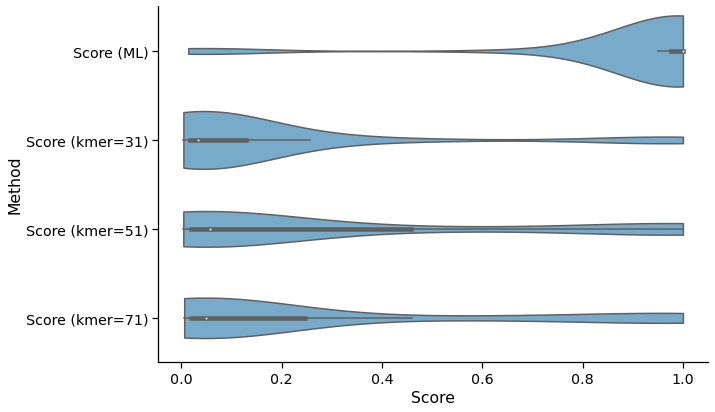

In [82]:
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.catplot(data=scores_long_df, kind="violin",
                    y="Method", x="Score", hue=None,
                    scale='area', inner='box',
                    ci=None, height=6, aspect=1.7,
                    cut=0,
                    color="#6baed6", edgecolor="black")
    plt.savefig('figures/tree-clustering-500.pdf')

## 4.7 Visualize clusters

### 4.7.1. ML Tree

/home/CSCScience.ca/apetkau/miniconda3/envs/gdi-sars-cov-2/lib/python3.8/site-packages/genomics_data_index/api/query/impl/DataFrameSamplesQuery.py:143: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  self._data_frame[isa_column].str.contains(data))


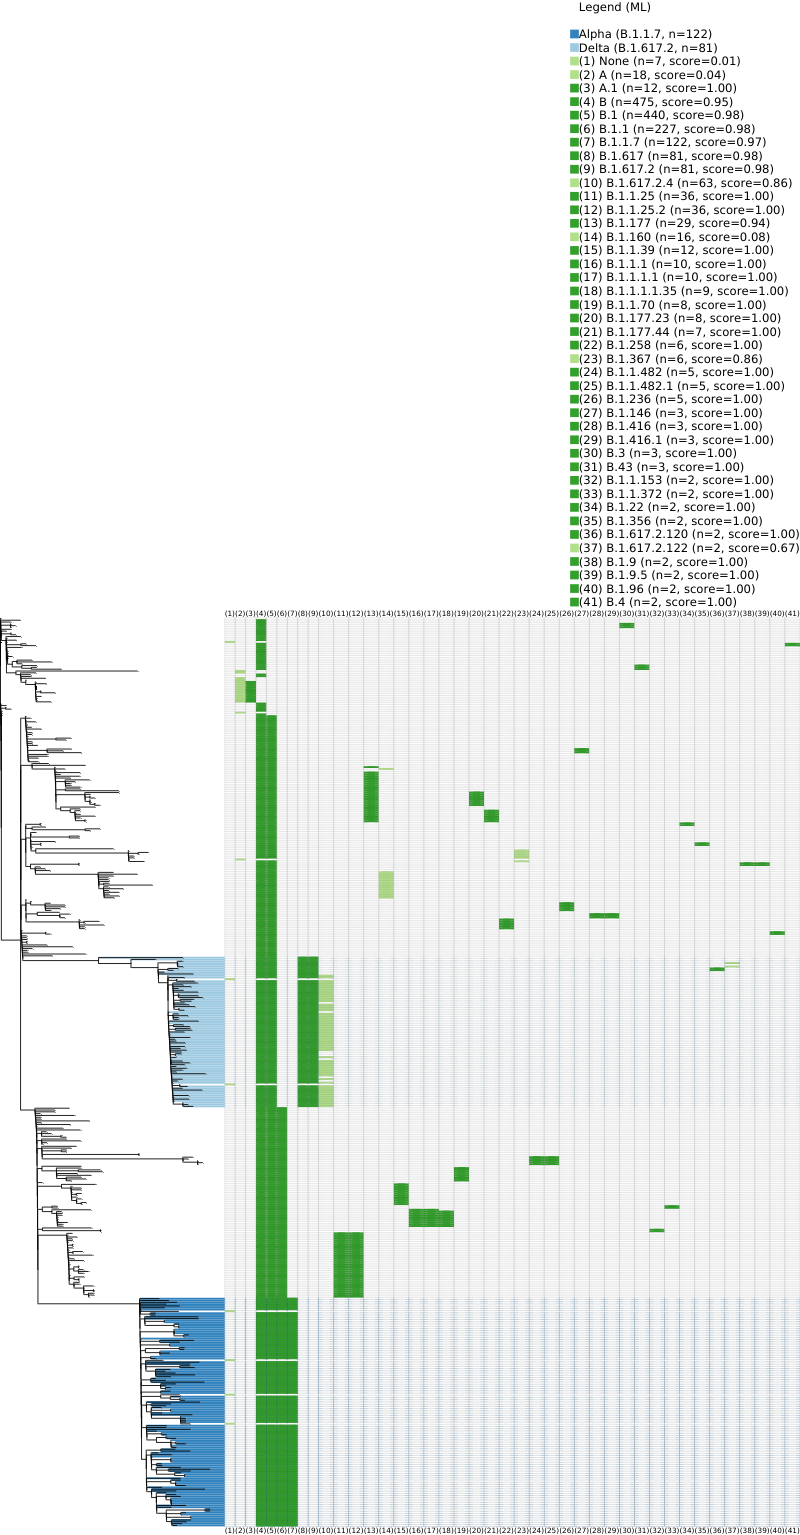

In [83]:
from genomics_data_index.api.viewer.TreeStyler import TreeStyler, HighlightStyle
from genomics_data_index.api.query.SamplesQuery import SamplesQuery
from typing import List, Dict, Tuple

highlight_style = HighlightStyle.create(colors=['#3182bd', '#9ecae1'])

def annotate_lineages(ts: TreeStyler, query: SamplesQuery,
                      scores_df: pd.DataFrame, score_label_column: str,
                      color_column: str) -> TreeStyler:
    for index, row in scores_df.iterrows():
        lineage = row['lineage']
        order_label = row['Order label']
        score_label = row[score_label_column]
        color = row[color_column]
        
        lineage_regex = lineage.replace('.', '\\.')
        ts = ts.annotate(query.isa(fr'^{lineage_regex}($|\.)', isa_column='lineage', kind='dataframe', regex=True),
                         legend_label=score_label, box_label=order_label, color_present=color)
        
    return ts

def tree_cluster_figure(q: SamplesQuery, size: int, type_suffix: str,
                        annotate_label_factor: float = 0.75,
                        tree_scale: int = 20000000):
    legend_title = f'Legend {type_suffix}'
    score_label_column = f'Label {type_suffix}'
    color_column = f'Color {type_suffix}'
    legend_size_factor = 1.2
    
    ts = q.tree_styler(mode='r', highlight_style=highlight_style,
                       legend_nsize=size*legend_size_factor, legend_fsize=size*legend_size_factor,
                       annotate_opacity_absent=1.0,
                       annotate_border_width=10,
                       annotate_box_width=size, annotate_box_height=size/4,
                       legend_type_label_present='', legend_type_label_unknown='',
                       legend_title=legend_title, annotate_show_box_label=False,
                       include_unknown=False, annotate_color_unknown='black',
                       show_leaf_names=False, annotate_guiding_lines=False,
                       annotate_label_fontsize=size*annotate_label_factor,
                       tree_scale=tree_scale, tree_line_width=120,
                       leaf_name_fontsize=size/2.5,
                      )
    
    # Highlight variants of concern (https://www.who.int/en/activities/tracking-SARS-CoV-2-variants/)
    # Also from https://cov-lineages.org/lineage_list.html
    vocs = [('Alpha', 'B.1.1.7'),
            ('Beta', 'B.1.351'),
            ('Gamma', 'B.1.1.28.1'),
            ('Delta', 'B.1.617.2'),
            ('Epsilon', 'B.1.427'),
            ('Zeta', 'B.1.1.28.2'),
            ('Eta', 'B.1.525'),
            ('Theta', 'B.1.1.28.3'),
            ('Iota', 'B.1.526'),
            ('Lambda', 'B.1.1.1.37'),
            ('Omicron', 'B.1.1.529'),
           ]
    for name, lineage in vocs:
        lineage_regex = lineage.replace('.', '\\.')
        qvoc = q.isa(fr'^{lineage_regex}($|\.)', isa_column='lineage', kind='dataframe', regex=True)
        if len(qvoc) > 0:
            ts = ts.highlight(qvoc, legend_label=f'{name} ({lineage}, n={len(qvoc)})')
    
    ts = ts.add_spacing(width=size*2)
    # ts = ts.add_spacing(width=size/2, color='white')
    
    ts = annotate_lineages(ts, query=q, scores_df=scores_df,
                           score_label_column=score_label_column, color_column=color_column)

    return ts

def render_jupyter(ts: TreeStyler):
    return ts.render(w=800, ladderize=True)

def render_file(ts: TreeStyler, file_name: str):
    ts.render(file_name=file_name, w=3200, ladderize=True)
    return file_name
    
tsml = tree_cluster_figure(q=q, size=1000, type_suffix='(ML)')
render_jupyter(tsml)

In [84]:
render_file(tsml, file_name='figures/tree-cluster-ml.png')

'figures/tree-cluster-ml.png'

### 4.7.2. Kmer=31 tree

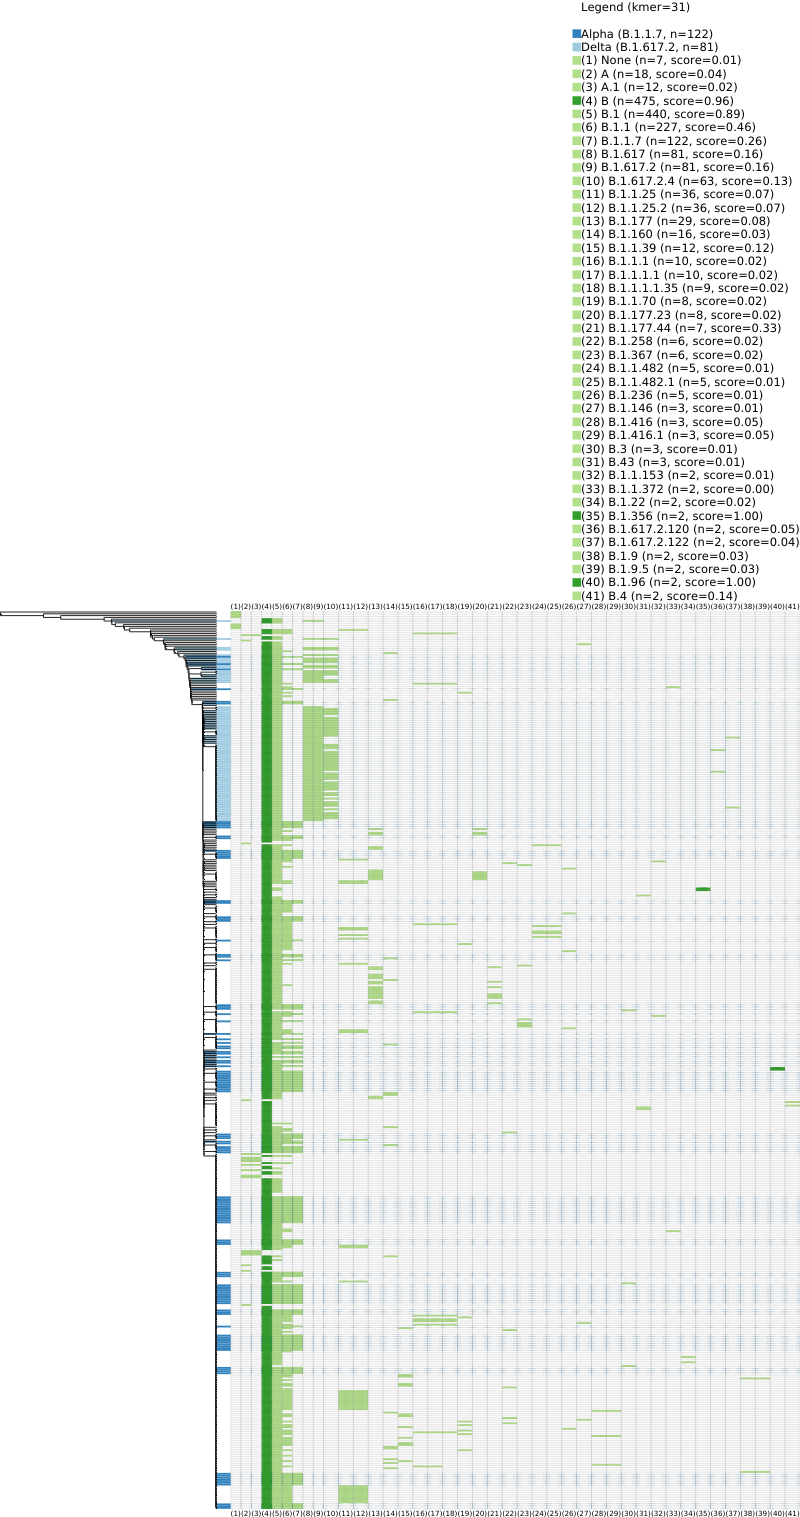

In [85]:
ts31 = tree_cluster_figure(q=q31, size=1000, type_suffix='(kmer=31)', tree_scale=120000)
render_jupyter(ts31)

In [86]:
render_file(ts31, file_name='figures/tree-cluster-kmer-31.png')

'figures/tree-cluster-kmer-31.png'

### 4.7.3. Kmer=51 tree

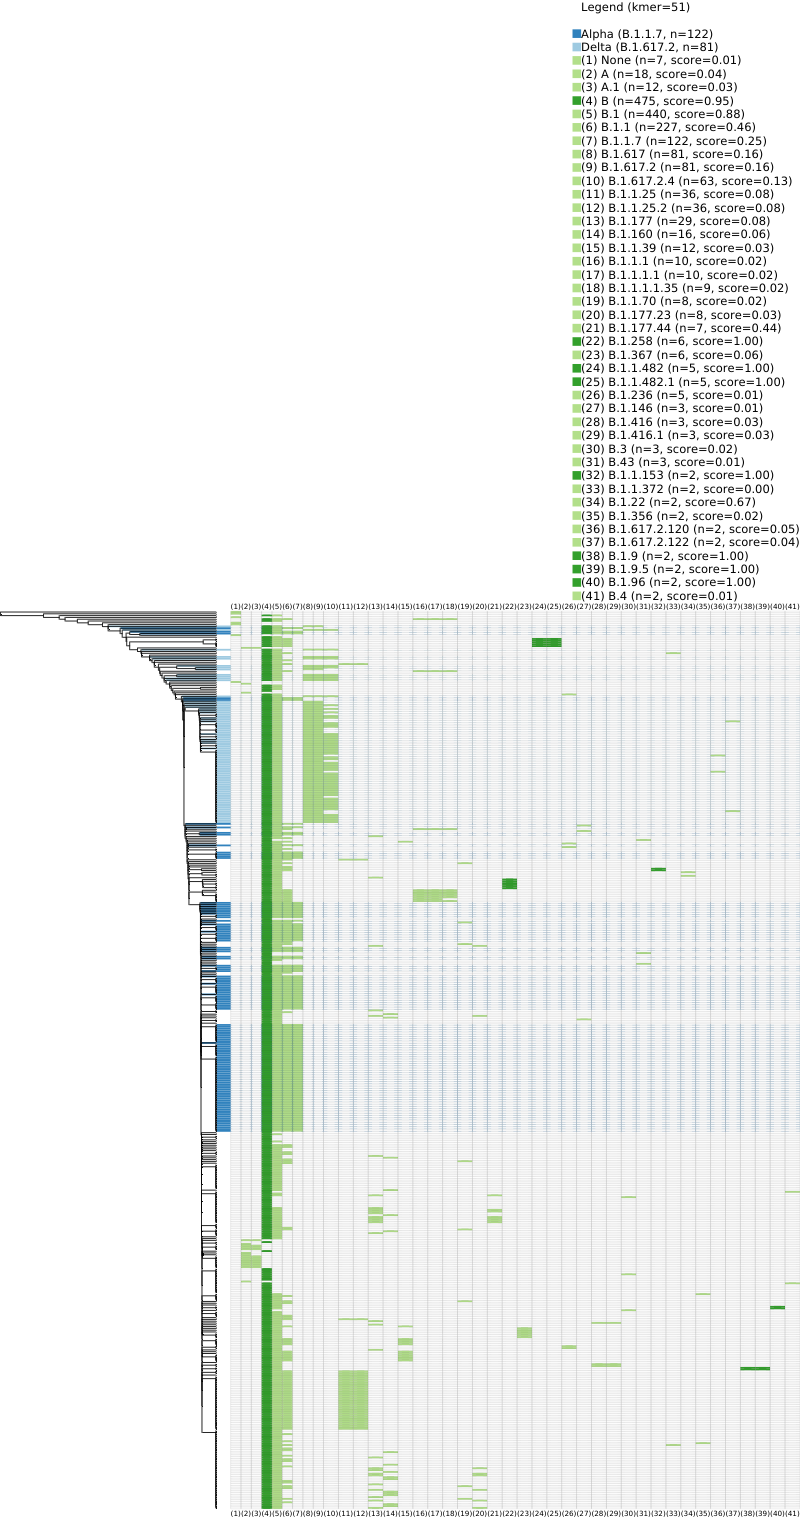

In [87]:
ts51 = tree_cluster_figure(q=q51, size=1000, type_suffix='(kmer=51)', tree_scale=120000)
render_jupyter(ts51)

In [88]:
render_file(ts51, file_name='figures/tree-cluster-kmer-51.png')

'figures/tree-cluster-kmer-51.png'

### 4.7.4. Kmer=71 tree

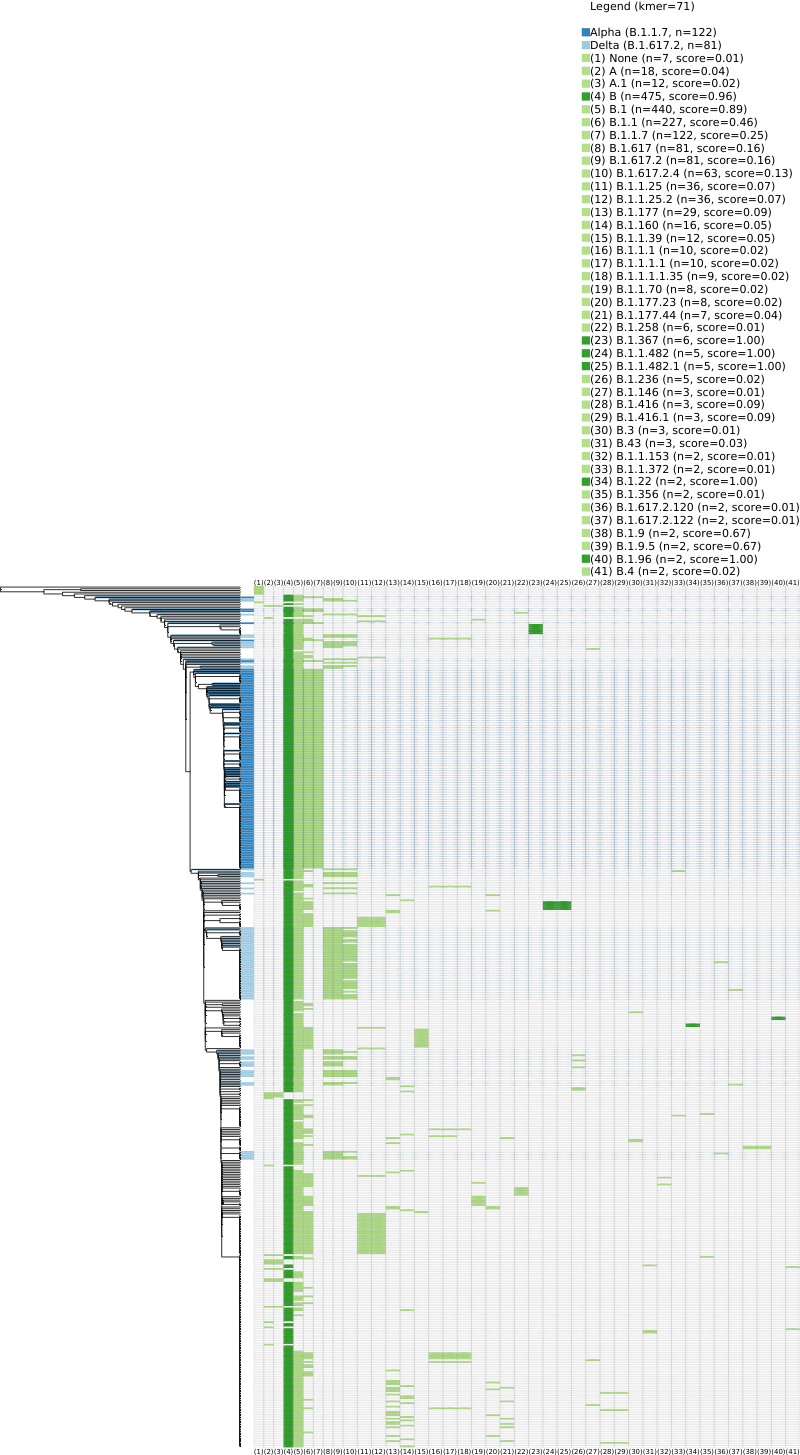

In [89]:
ts71 = tree_cluster_figure(q=q71, size=1000, type_suffix='(kmer=71)', tree_scale=120000)
render_jupyter(ts71)

In [90]:
render_file(ts71, file_name='figures/tree-cluster-kmer-71.png')

'figures/tree-cluster-kmer-71.png'